Fit white light edge data (for simulations where the edge detection worked well and is fairly robust) by two techniques:

1. Sheeley et al. 1999 - exponential deceleration

2. Low 1984 - Self similar MHD - deceleration of shock surface to inertial flows

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [2]:
import re
import os

In [3]:
from multiprocessing import Pool
from itertools import repeat

In [4]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

import re
import os

from multiprocessing import Pool
from itertools import repeat

In [5]:
%matplotlib inline

In [6]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [7]:
# print(plt.rcParams)

In [8]:
import edge_utils as edut

In [9]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [10]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [11]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [12]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

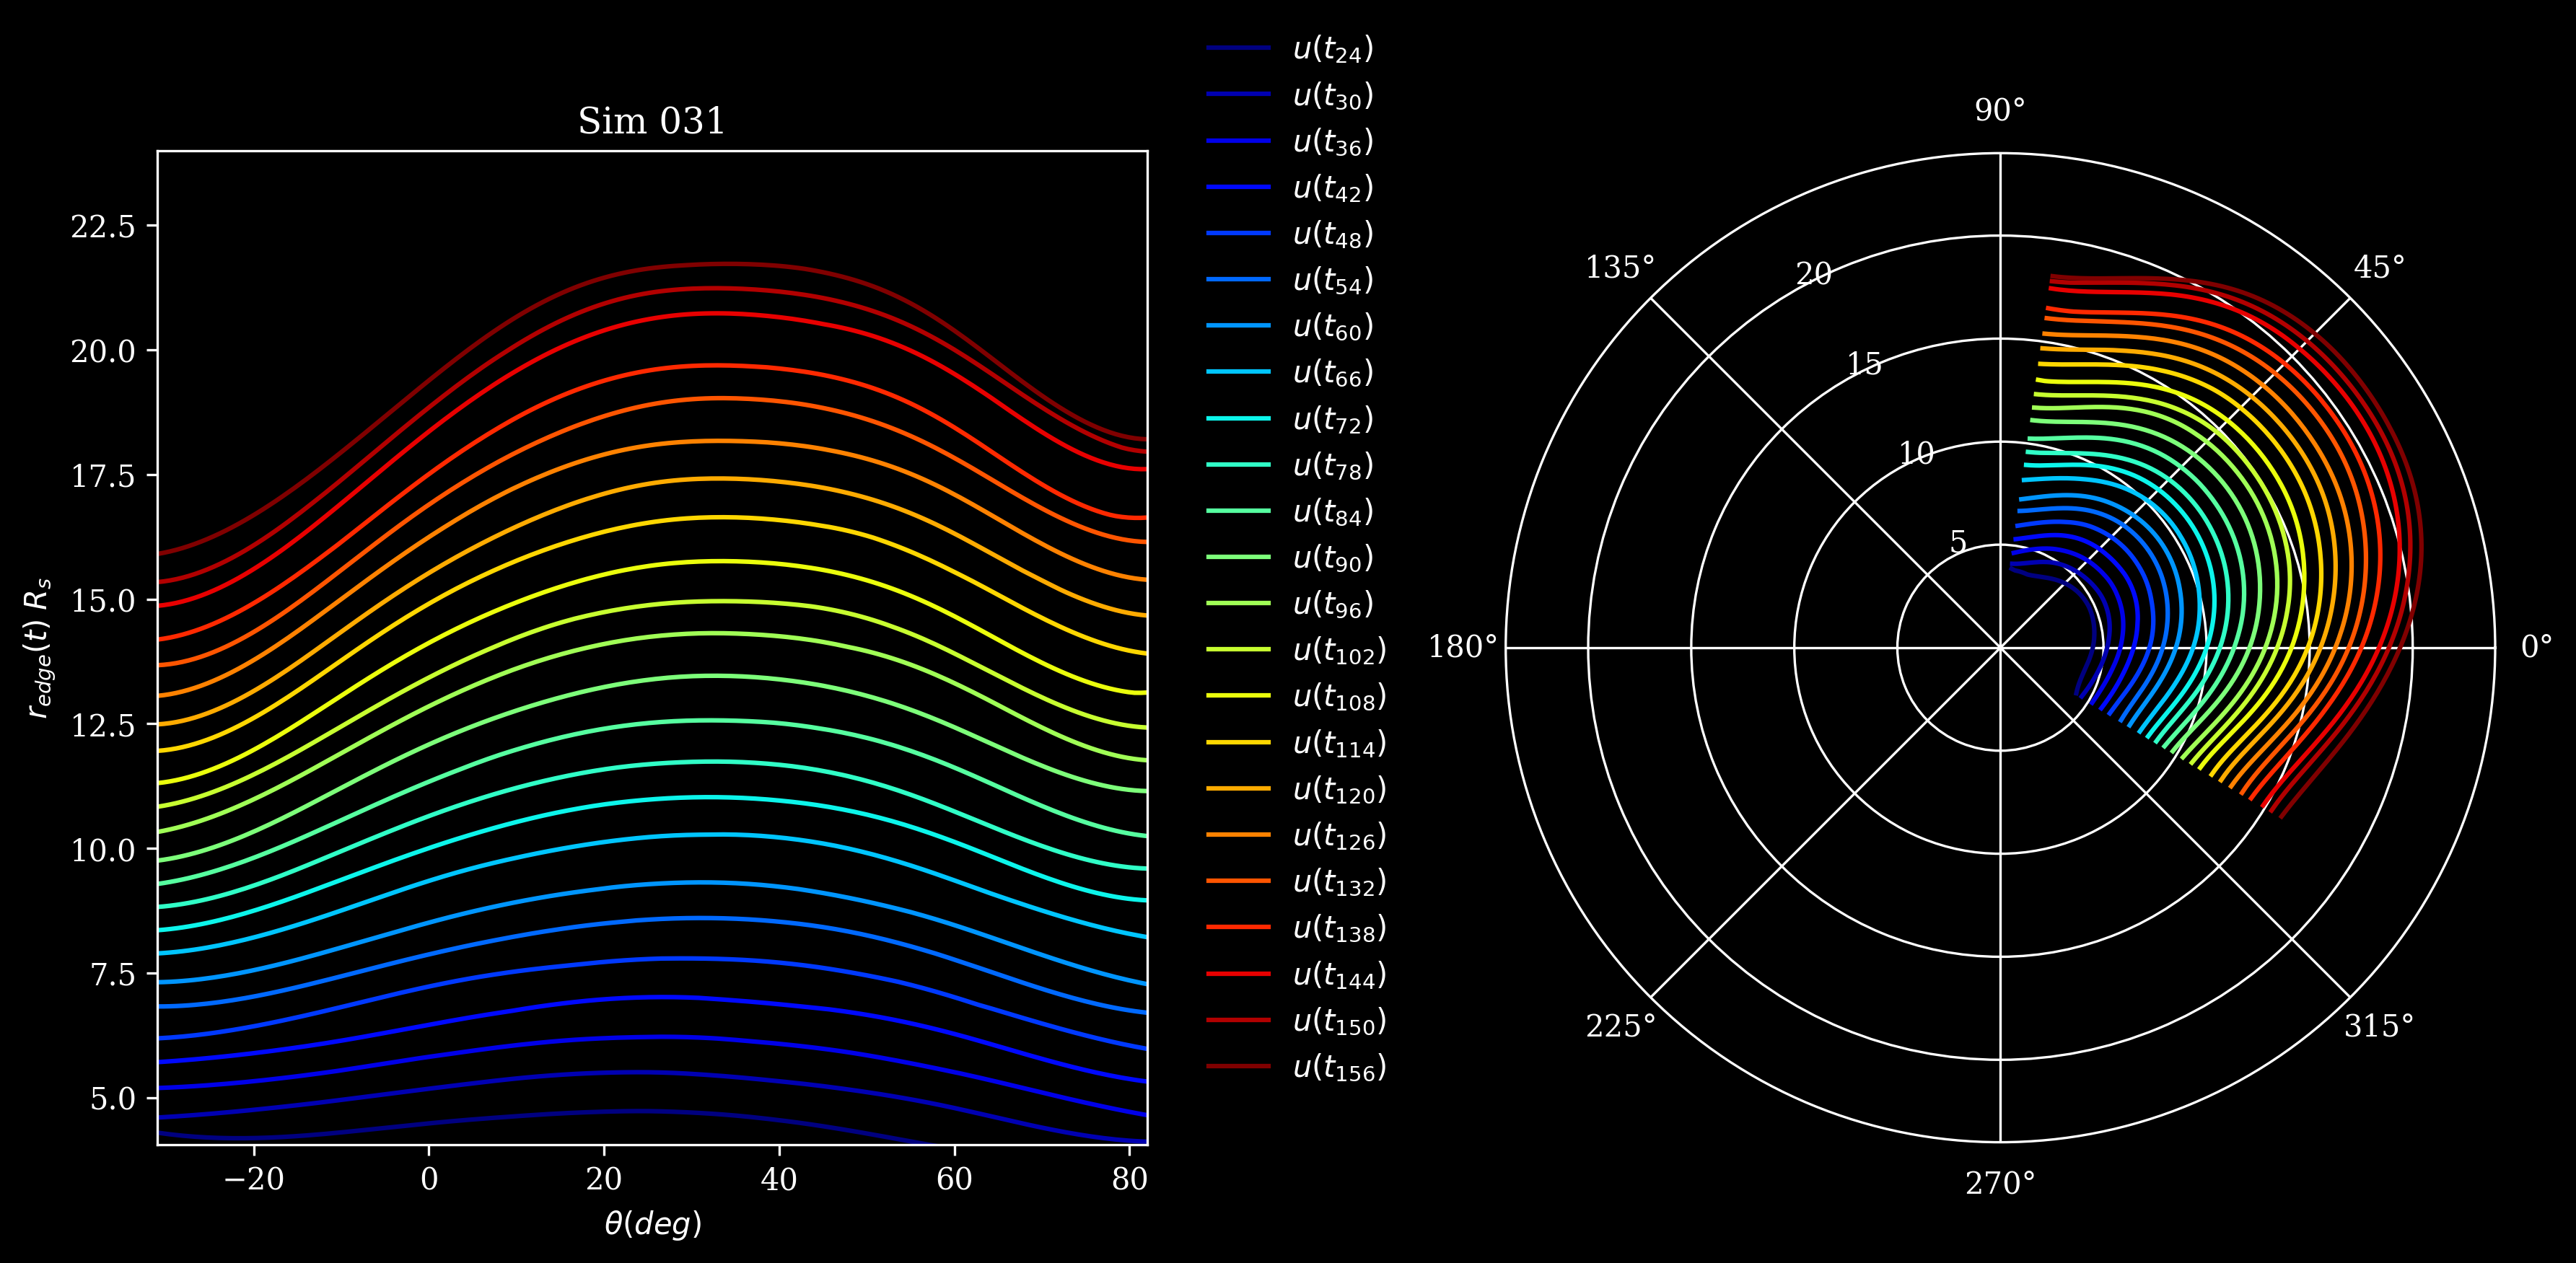

In [13]:
edut.plotCartesianPolarEdges(ed_2161, sd_2161, theta=theta_grid, simIdx=0)

**Part 1: Sheeley et al**

For all position angles, we fit the following equation for known initial edge location $r_0$:

$$r = k  \tau^2 \exp(-t / \tau) + c_1 t + r_0$$

Because of the constant $c_1 t$ we can't linearize by solving for the log. Instead, we use non-linear least squares. Below is a demo from `scipy.optimize` with the [Levenberg-Marquadt algorithm](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) where the objective function is linearized and the residual is solved to yield an estimate of perturbation $\delta$ for the parameters. A adaptively "damped" or Tikhonov-regularized least squares problem combined with scaling of the gradient components according to curvature are the key ingredients.

With the constraint that $c_1 >= 0$ since $c_1$ represents $dr/dt$ at $t=0$, `scipy.optimize` uses Trust Region Reflective Algorithm.

In [14]:
from numpy.random import default_rng
rng = default_rng()

def gen_data(t, a, b, c, noise=0., n_outliers=0, seed=None):
    rng = default_rng(seed)

    y = a + b * np.exp(t * c)

    error = noise * rng.standard_normal(t.size)
    outliers = rng.integers(0, t.size, n_outliers)
    error[outliers] *= 10

    return y + error

a = 0.5
b = 2.0
c = -1
t_min = 0
t_max = 10
n_points = 15

t_train = np.linspace(t_min, t_max, n_points)
y_train = gen_data(t_train, a, b, c, noise=0.1, n_outliers=3)

In [15]:
def fun(x, t, y):
    return x[0] + x[1] * np.exp(x[2] * t) - y

x0 = np.array([1.0, 1.0, 0.0])

In [16]:
from scipy.optimize import least_squares

In [17]:
res_lsq = least_squares(fun, x0, args=(t_train, y_train))

In [18]:
res_soft_l1 = least_squares(fun, x0, loss='soft_l1', f_scale=0.1,
                            args=(t_train, y_train))
res_log = least_squares(fun, x0, loss='cauchy', f_scale=0.1,
                        args=(t_train, y_train))

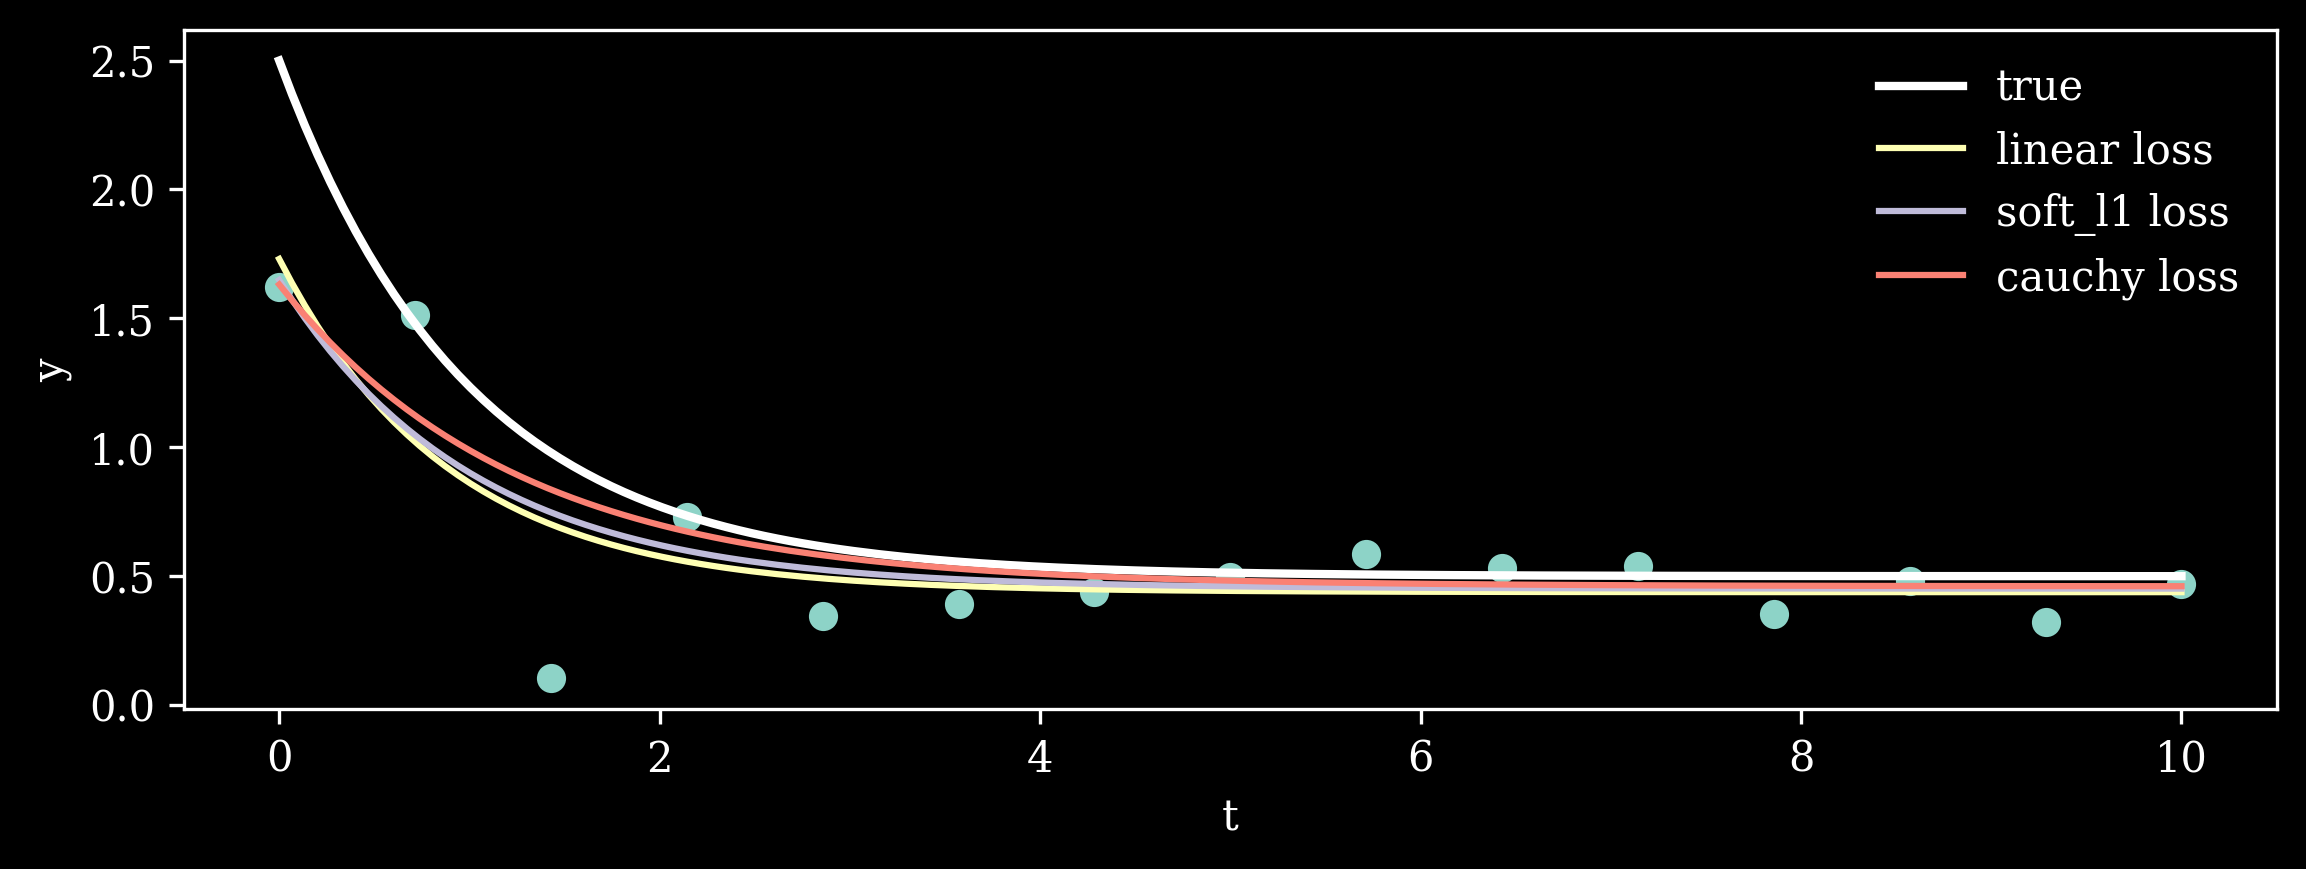

In [19]:
t_test = np.linspace(t_min, t_max, n_points * 10)
y_true = gen_data(t_test, a, b, c)
y_lsq = gen_data(t_test, *res_lsq.x)
y_soft_l1 = gen_data(t_test, *res_soft_l1.x)
y_log = gen_data(t_test, *res_log.x)

plt.plot(t_train, y_train, 'o')
plt.plot(t_test, y_true, color="white", linewidth=2, label='true')
plt.plot(t_test, y_lsq, label='linear loss')
plt.plot(t_test, y_soft_l1, label='soft_l1 loss')
plt.plot(t_test, y_log, label='cauchy loss')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()

Now we define the problem for all edges and all position angles:

In [20]:
def sheeley_exp(x, t, y):
    return x[0] * (x[1] ** 2) * np.exp(-t / x[1]) + x[2] * t - y

In [21]:
def gen_exp_data(t, k, tau, c1):
    y = k * (tau**2) * np.exp(-t / tau) + c1 * t
    return y

In [22]:
def fit_sheeley_exp(edge_data_matrix, sim_data, simIdx=0, 
                          theta=np.linspace(-31, 82, 160), 
                          lsq_loss="soft_l1",
                          fscale=0.1,
                          x0 = [55.6 * 18.6287, 3, 0.00517464 * 400]):
    """
    for a chosen sim ID, fit non-linear least squares to all valid times in edge data, varying with position angle.
    return matrix of size (n_theta x n_params), here n_params = 3
    """
    
    ntheta = len(theta)
    
    simID = sim_data[simIdx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)
    
    r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times])
    
    # rescale valid_times
    # convert time to hours from minutes
    #     valid_times_hrs = valid_times / 60
    valid_times_rs = (valid_times - tMin) / (tMax - tMin)
    
    lsq_params = np.zeros((ntheta, 3))
    
    r_vals_valid = r_vals[valid_time_idx, :]
    
    r0 = r_vals_valid[0, :]
    
    
    t_train = valid_times_rs[1:]
    r_train = r_vals_valid[1:, :] - r0
    
    r_pred = np.zeros(np.shape(r_vals_valid))
    
    r_pred[0, :] = r0
    
    for pa_idx, pa in enumerate(theta):
        res_lsq = least_squares(sheeley_exp,
                                x0,
                                loss=lsq_loss,
                                args=(t_train, r_train[:, pa_idx]),
                                bounds=([-np.inf, 0,  0], np.inf),
                                verbose=0)
        
        
        lsq_params[pa_idx, :] = res_lsq.x
        r_pred[1:, pa_idx] = gen_exp_data(t_train, *res_lsq.x) + r0[pa_idx]
    
    return lsq_params, r_pred, r_vals_valid

In [23]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [24]:
# sims to exclude - 33, 39, 63, 73, 113, 128, 131, 142,193, 218, 253, 264, 273, 312, 313, 324

**Plot side by side predictions on training data**

The below results are shown with default `linear` loss, the `soft_l1` loss causes wiggly solutions in some parts of the domain, and `linear` takes slightly longer to provide an optimal solution. Possibly one can try locally linear regression over different position angles to reduce the computation of optimal parameters over so many points for what is an otherwise smooth curve!

In [25]:
params_s0, r_pred_s0, r_vals_s0 = fit_sheeley_exp(ed_2161, sd_2161, simIdx=0, lsq_loss="linear")

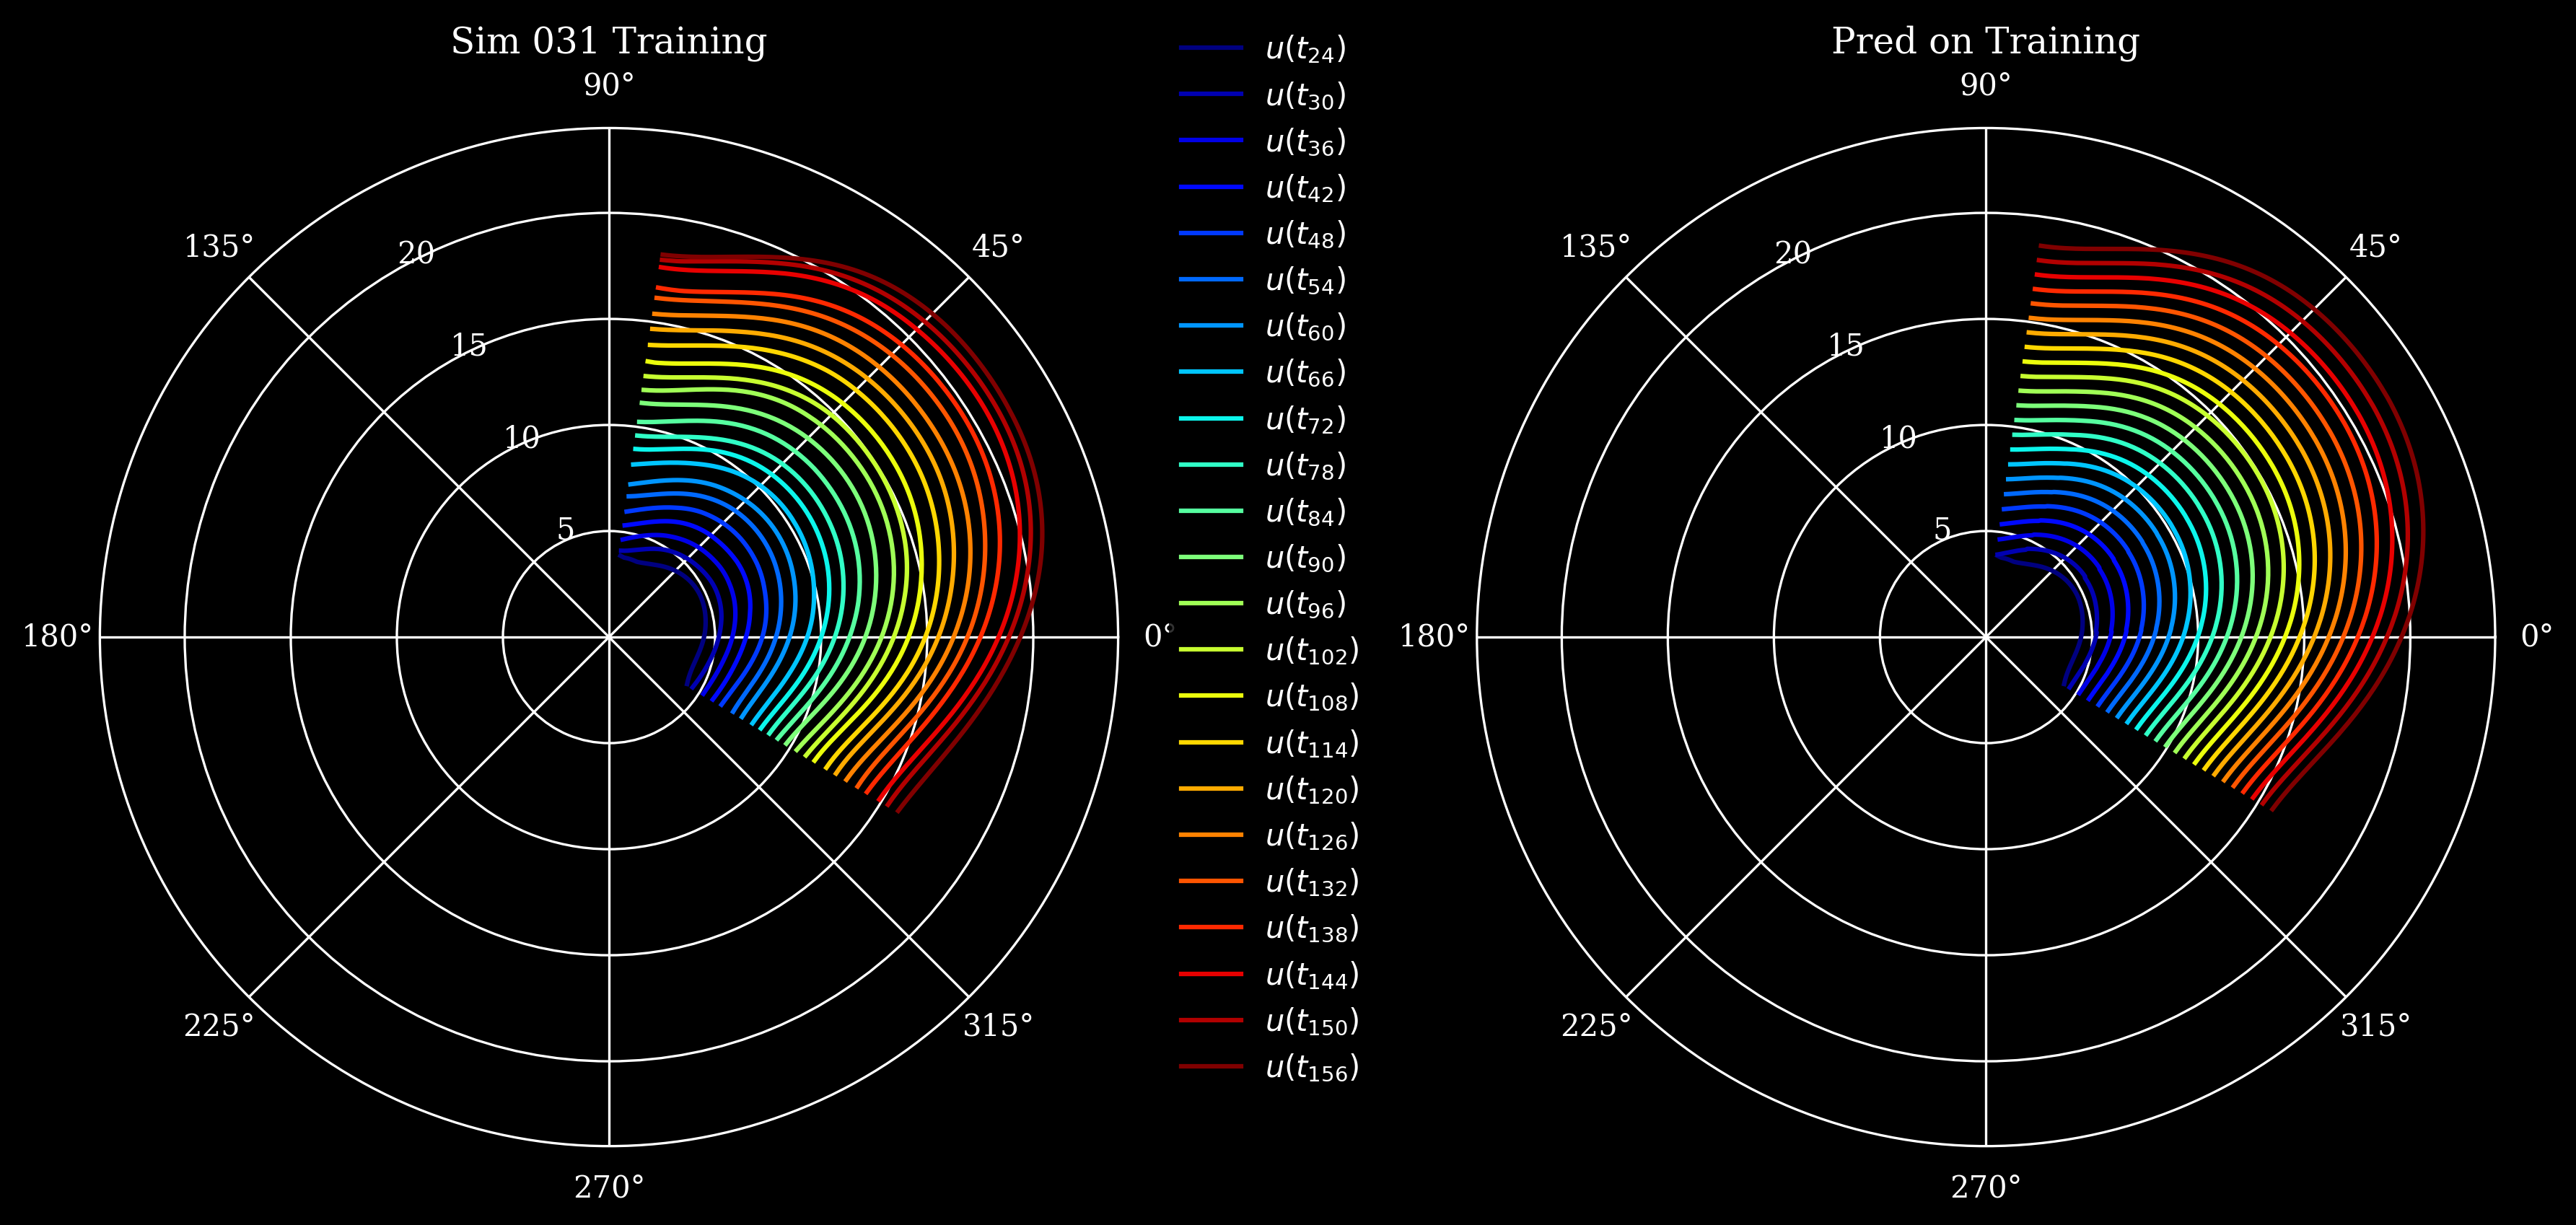

In [26]:
edut.plotTrainPredData(r_vals_s0, r_pred_s0, ed_2161, sd_2161, simIdx=0)

In [27]:
params_s1, r_pred_s1, r_vals_s1 = fit_sheeley_exp(ed_2161, sd_2161, simIdx=1, lsq_loss="linear")

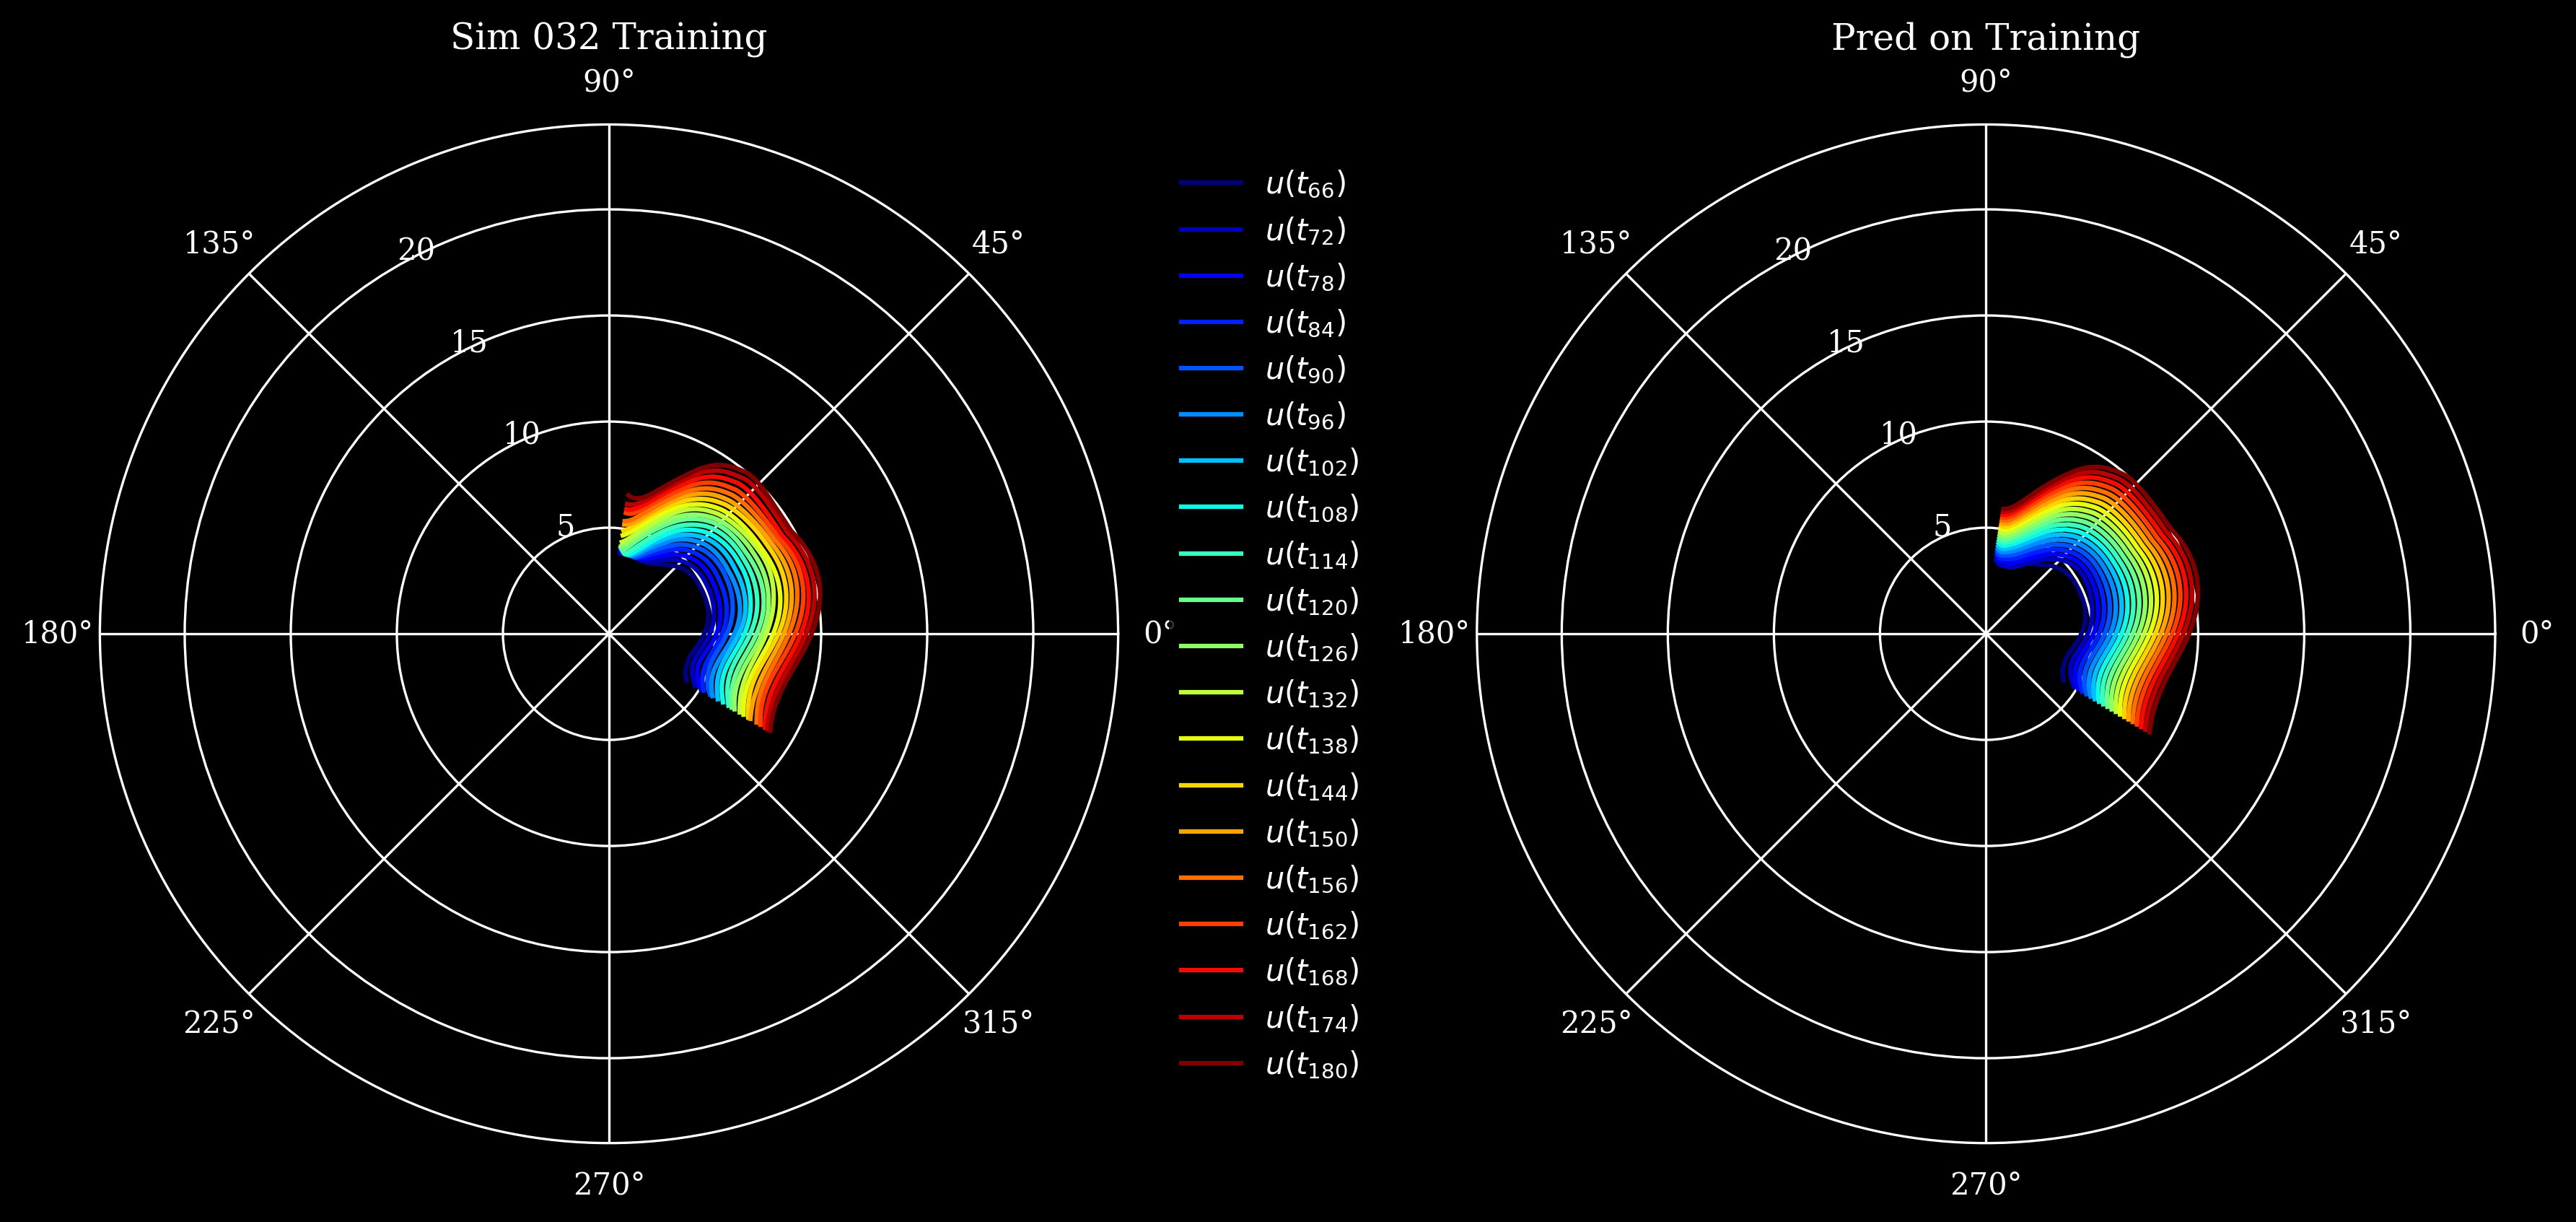

In [28]:
edut.plotTrainPredData(r_vals_s1, r_pred_s1, ed_2161, sd_2161, simIdx=1)

**Predictions on a test set?**

**Plots as a function of parameter space and the position angle!**

**Part 2: Low (1984)**

From the above work, we know that for spherically symmetric, time-dependent self-similar gas dynamic flows, the shock radius as a function of time is:

$$r(t) = r_0 \phi^{(7/6)}$$

where $\phi$ takes the form $k t^{\alpha}$ and $k$ and $\alpha$ change depending on the conditions i.e. acceleration to interial flow, deceleration to inertial flow, deceleration to state of rest etc. In our case, we consider these parameters variable w.r.t both position angle and the flux rope parameters of the simulation.

So solving the above amounts to a simpler least squares problem:

$$\log (r - r_0) = k + \alpha \log(t)$$

Some problems with taking the log however, since edges are not perfect. We can go around this by solving at a limited number of position angles, or solving by NLSS. We do the latter for now, and it doesn't seem to have a lot of predictive power

We don't impose any constraints on $k$ or $\alpha$, i.e. cover all scenarios.

In [29]:
from scipy.linalg import lstsq

In [30]:
def low_ss(x, t, y):
    """
    Models the above linearized version of the shock radius function, i.e. y is supplied in log.
    """
    return x[0] + x[1] * np.log(t) - y

In [31]:
def low_ss2(x, t, y):
    """
    Models the og version of shock radius
    """
    return x[0] * (t ** x[1]) - y

In [32]:
def gen_pow_data_2(t, k, alpha):
    y = k * (t ** alpha)
    return y

In [33]:
def gen_pow_data(t, k, alpha):
    y = k + alpha * np.log(t)
    return y

In [34]:
def fit_low_ss(edge_data_matrix, sim_data, simIdx=0, 
            theta=np.linspace(-31, 82, 160),
            lsq_loss="soft_l1",
            fscale=0.1,
            x0 = [2, 7/12]):
    """
    for a chosen sim ID, fit non-linear least squares to all valid times in edge data, varying with position angle.
    return matrix of size (n_theta x n_params), here n_params = 2
    """
    
    ntheta = len(theta)
    
    simID = sim_data[simIdx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)
    
    r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times])
    
    #     return valid_time_idx
    
    # rescale valid_times
    # convert time to hours from minutes
    #     valid_times_hrs = valid_times / 60
    valid_times_rs = (valid_times - tMin) / (tMax - tMin)
    
    lsq_params = np.zeros((ntheta, 2))
    
    r_vals_valid = r_vals[valid_time_idx, :]
    
    #     return r_vals_valid
    r0 = r_vals_valid[0, :]
    
    t_train = valid_times_rs[1:]
    #     r_train = np.log(r_vals_valid[1:, :] - r0)
    
    r_train = r_vals_valid[1:, :] / r0
    r_pred = np.zeros(np.shape(r_vals_valid))
    
    r_pred[0, :] = r0
    
    #     T_train = np.vstack((np.ones(len(t_train)), np.log(t_train))).T
    
    #     return r_train, T_train
    for pa_idx, pa in enumerate(theta):
        res_lsq = least_squares(low_ss2,
                                x0,
                                loss=lsq_loss,
                                args=(t_train, r_train[:, pa_idx]),
                                verbose=0)
        lsq_params[pa_idx, :] = res_lsq.x
        r_pred[1:, pa_idx] = gen_pow_data_2(t_train, *res_lsq.x) * r0[pa_idx]
        
    #         res_lsq = lstsq(T_train, r_train)

    #         lsq_params[pa_idx, :] = res_lsq[0]
    #         r_pred[1:, pa_idx] = np.exp(gen_pow_data(t_train, *res_lsq[0])) + r0[pa_idx]

    return lsq_params, r_pred, r_vals_valid

In [35]:
params_s0_low, r_pred_s0_low, r_vals_s0_low = fit_low_ss(ed_2161, sd_2161, simIdx=0, lsq_loss="linear")

In [36]:
params_s0_low.shape

(160, 2)

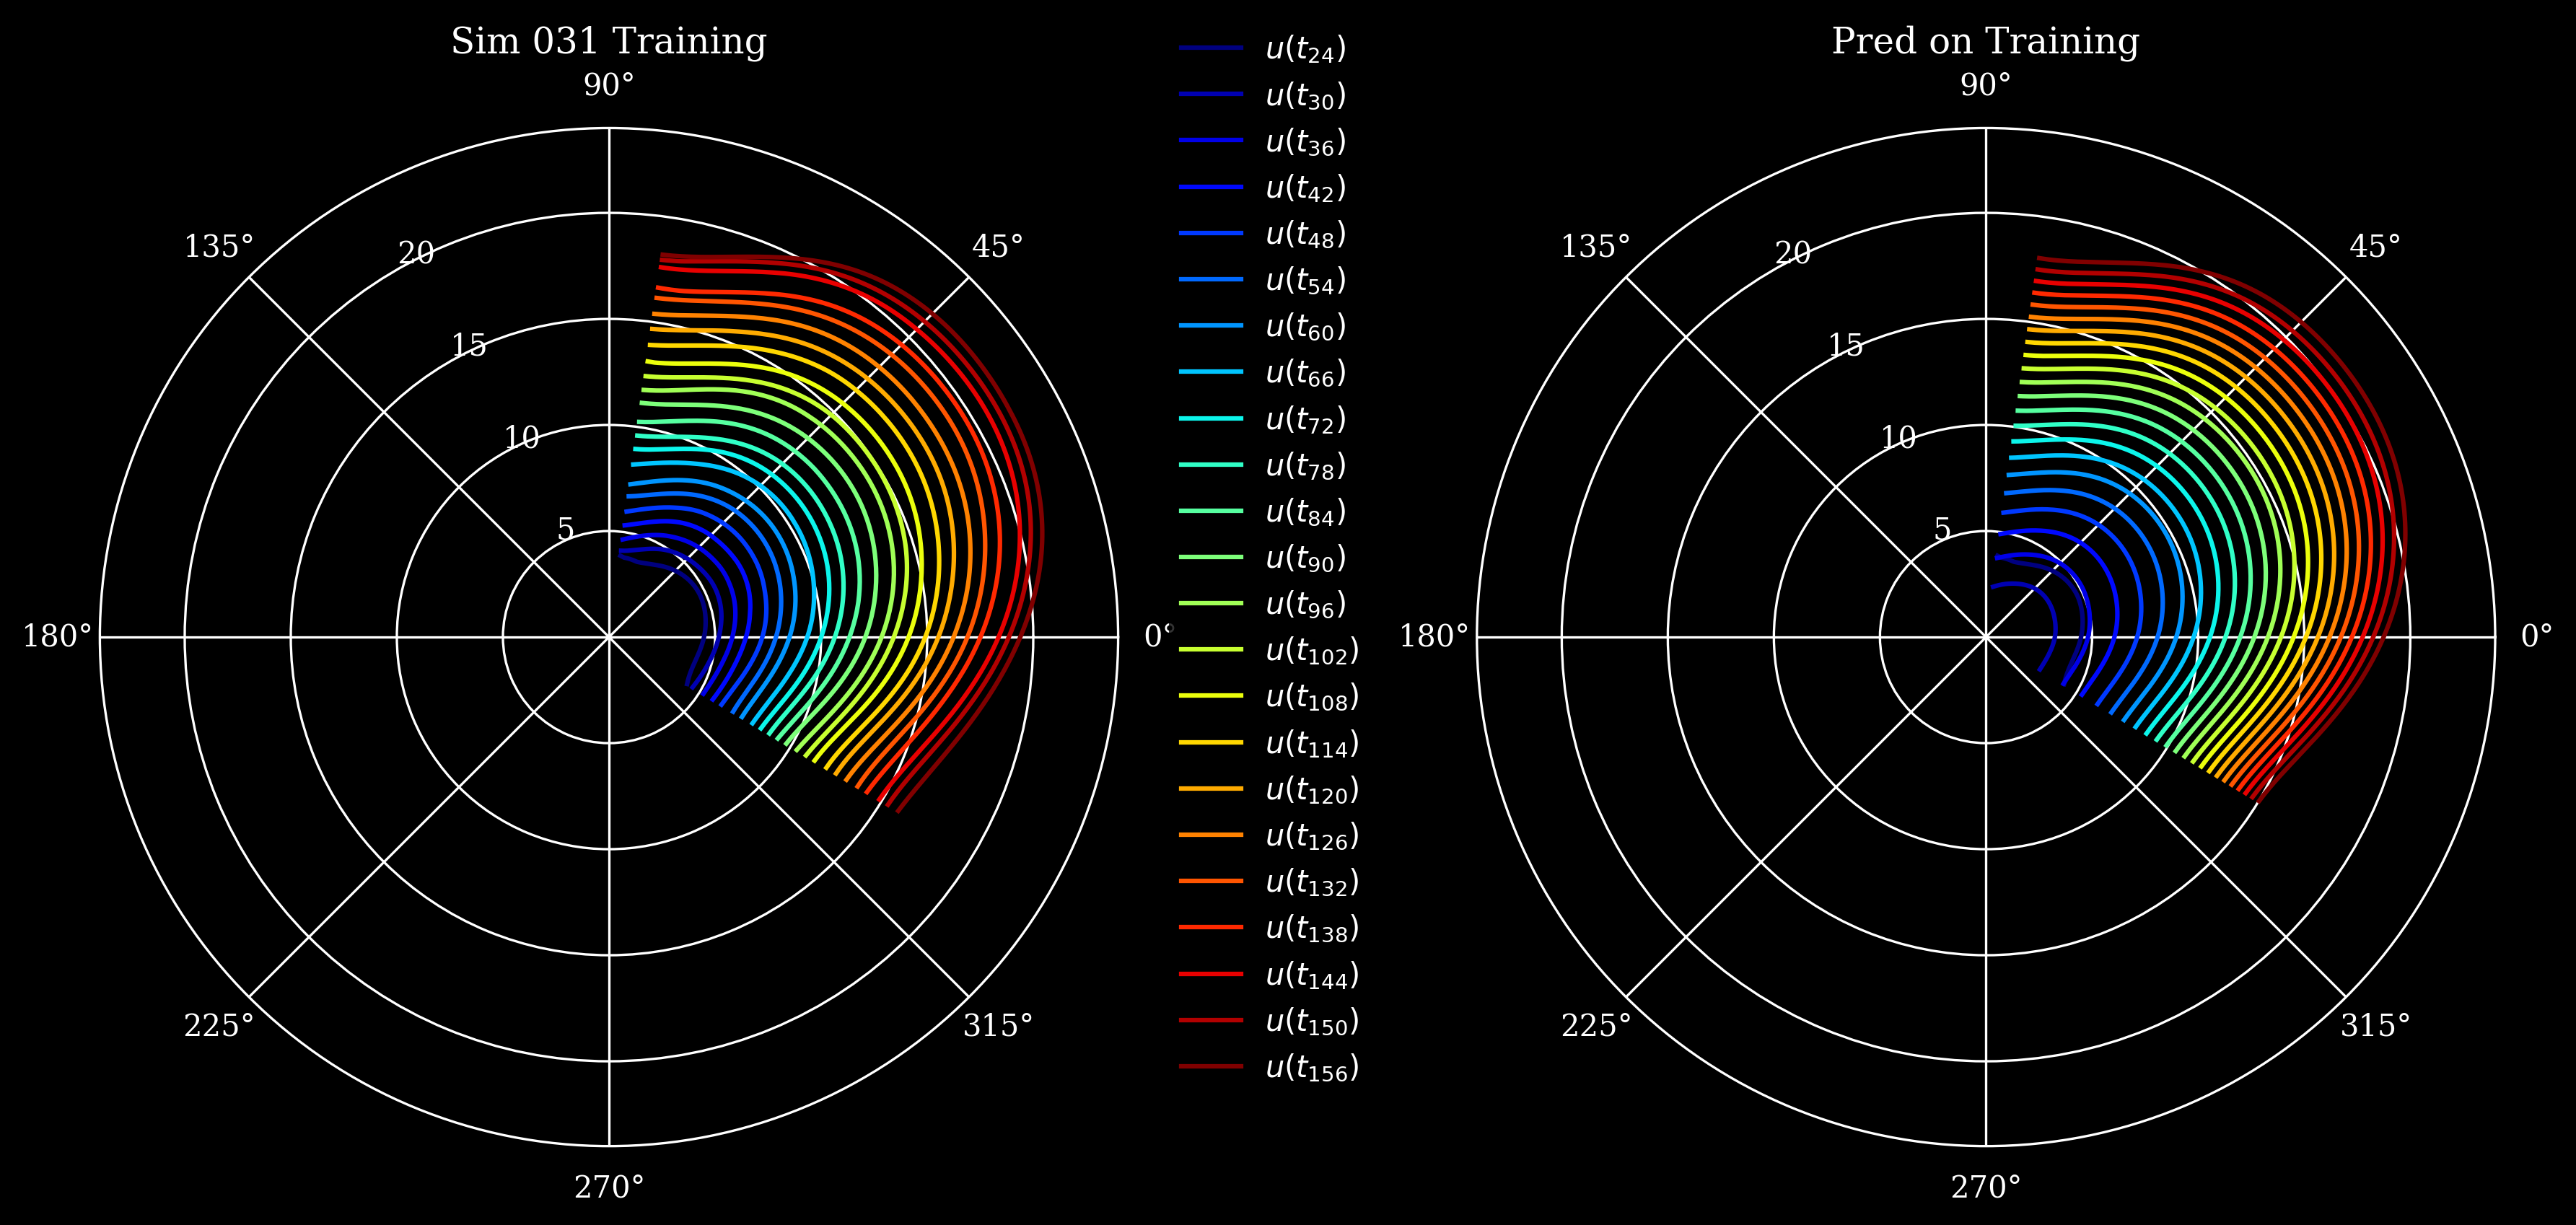

In [37]:
edut.plotTrainPredData(r_vals_s0_low, r_pred_s0_low, ed_2161, sd_2161, simIdx=0)

In [38]:
params_s1_low, r_pred_s1_low, r_vals_s1_low = fit_low_ss(ed_2161, sd_2161, simIdx=1, lsq_loss="linear")

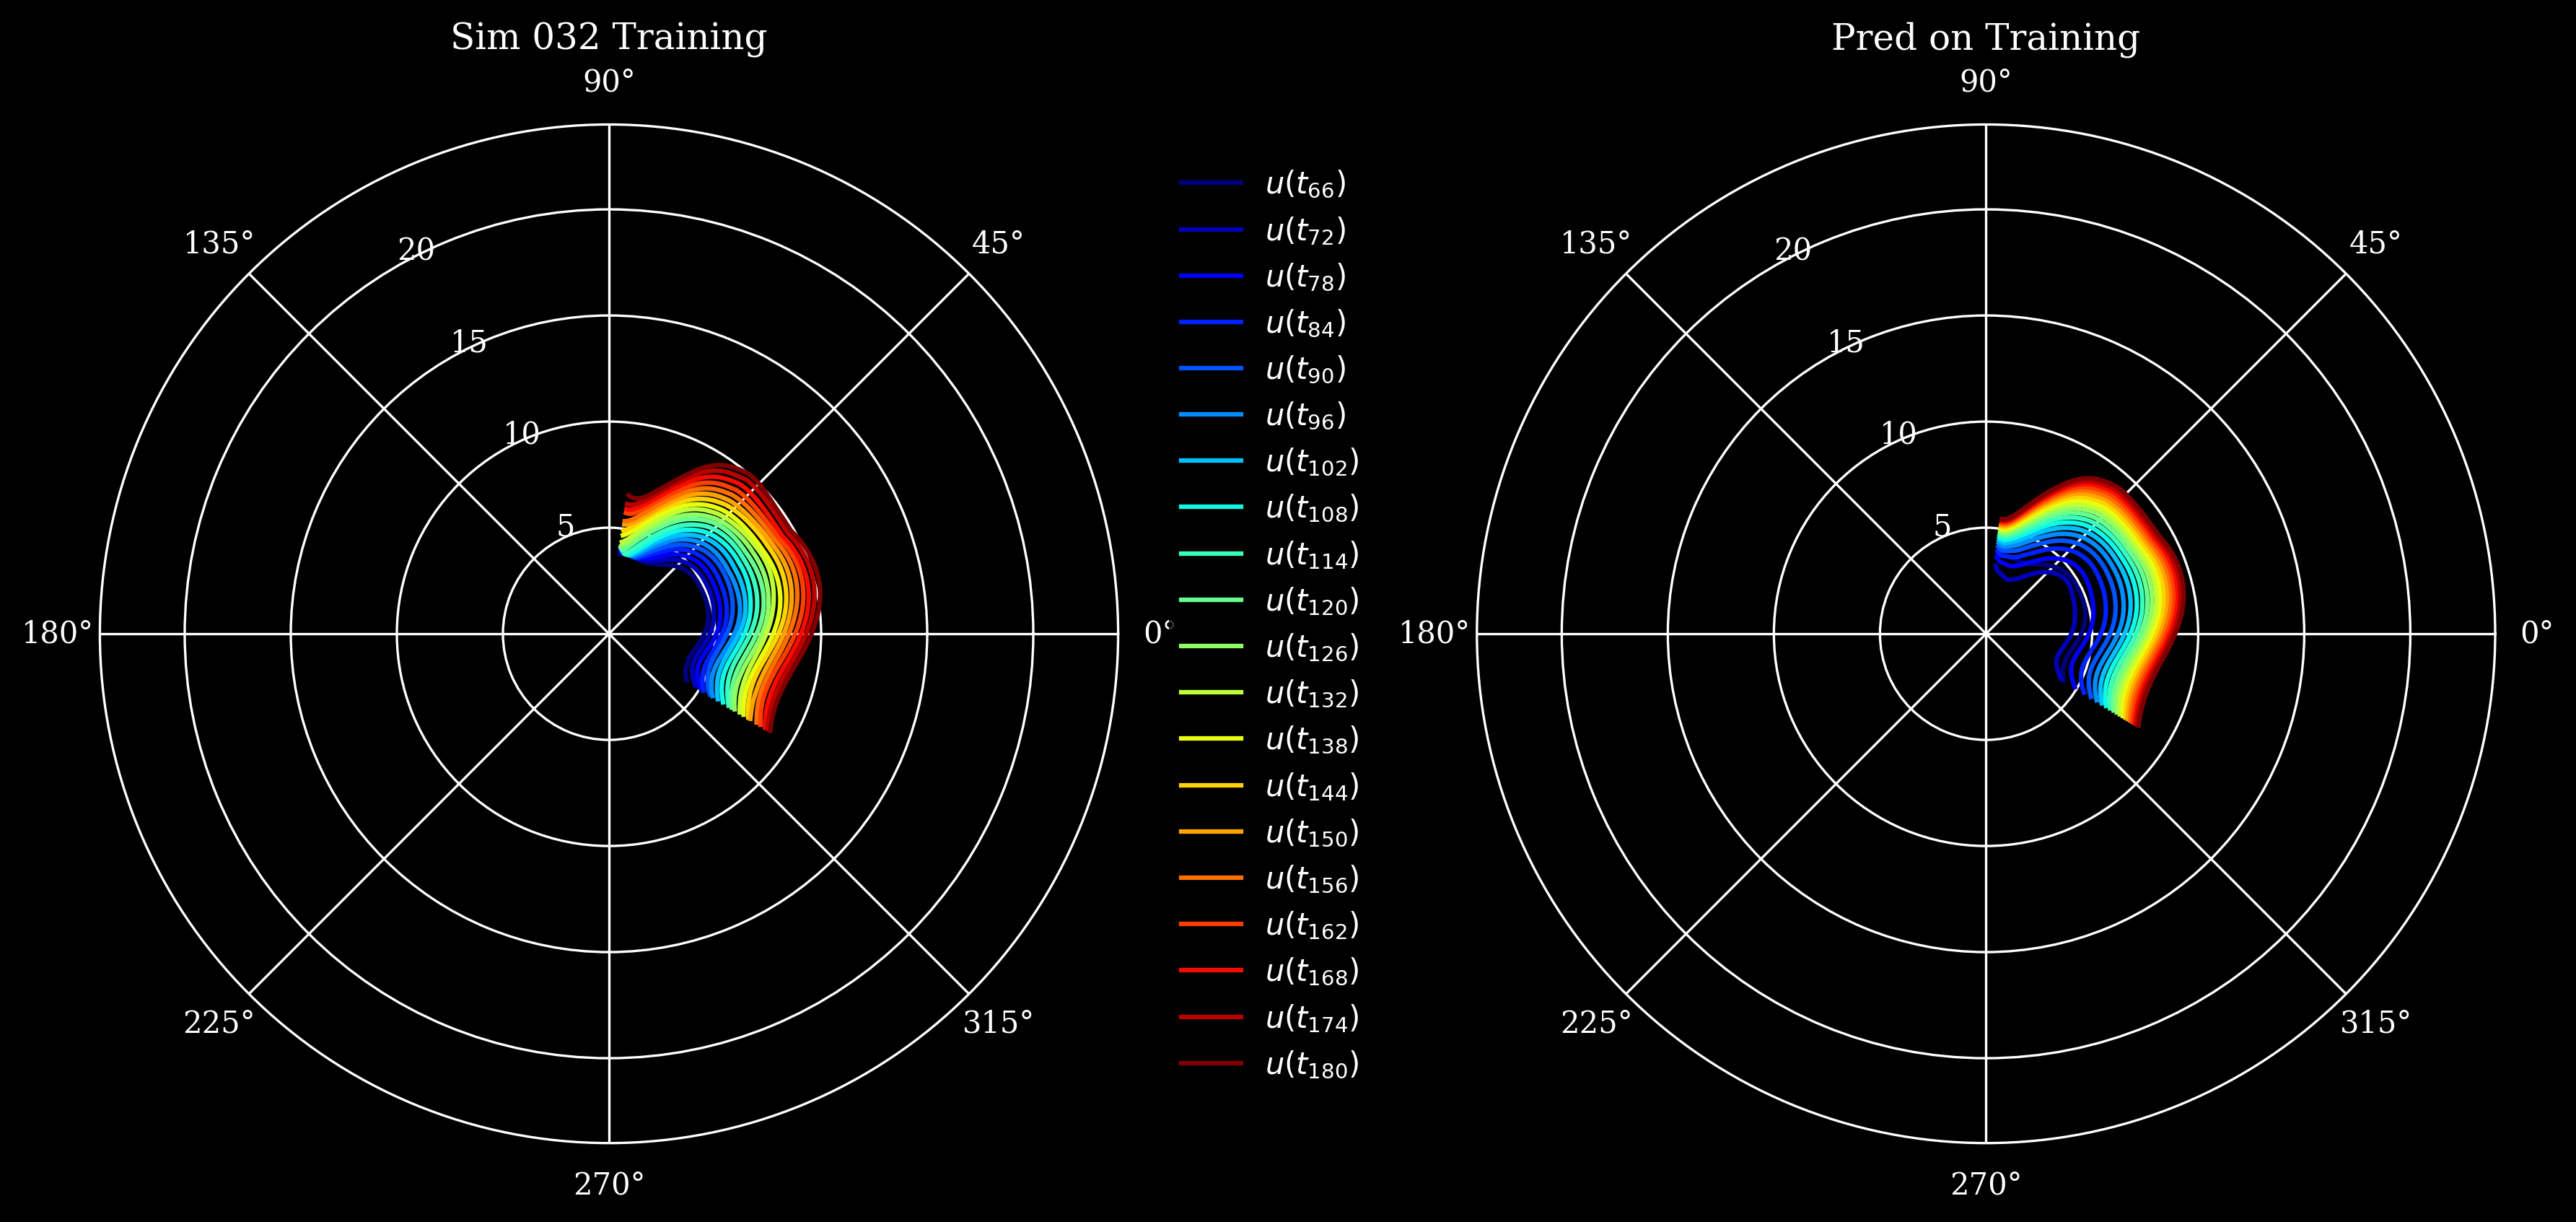

In [39]:
edut.plotTrainPredData(r_vals_s1_low, r_pred_s1_low, ed_2161, sd_2161, simIdx=1)

Next, we show training data, and the prediction on the training data in the same figure, i.e. figure on the left will have dotted lines showing Sheeley predictions, figure on the right will show Low predictions.

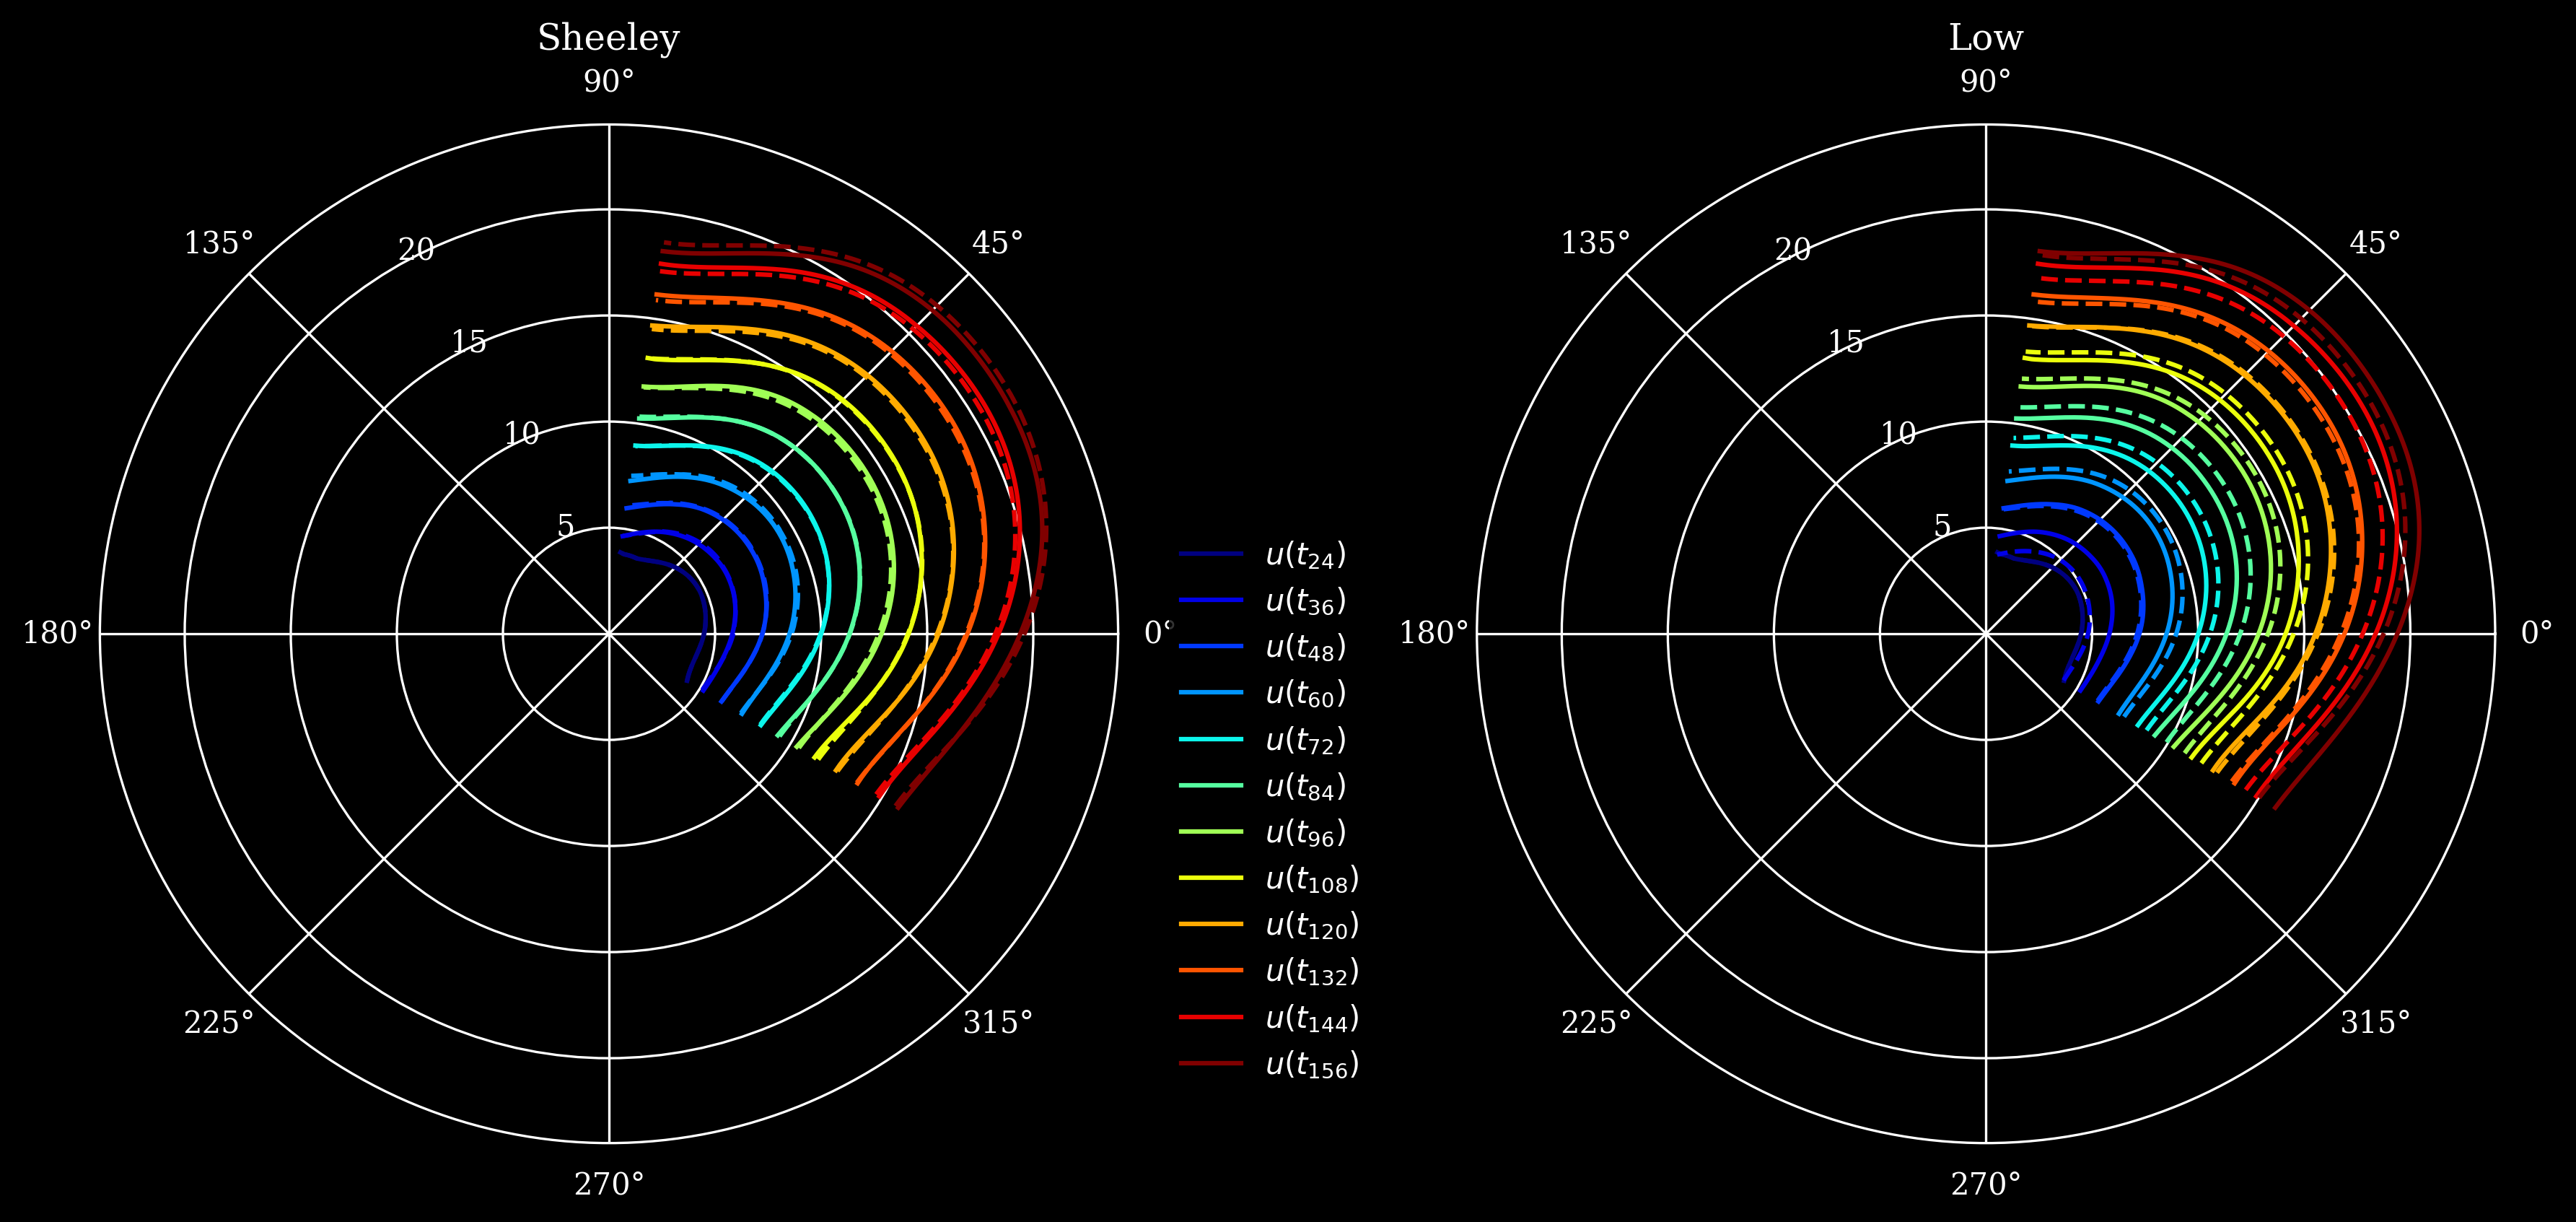

In [40]:
edut.plotTrainPredData2Models(r_vals_s0, r_pred_s0, r_pred_s0_low, ed_2161, sd_2161, simIdx=0)

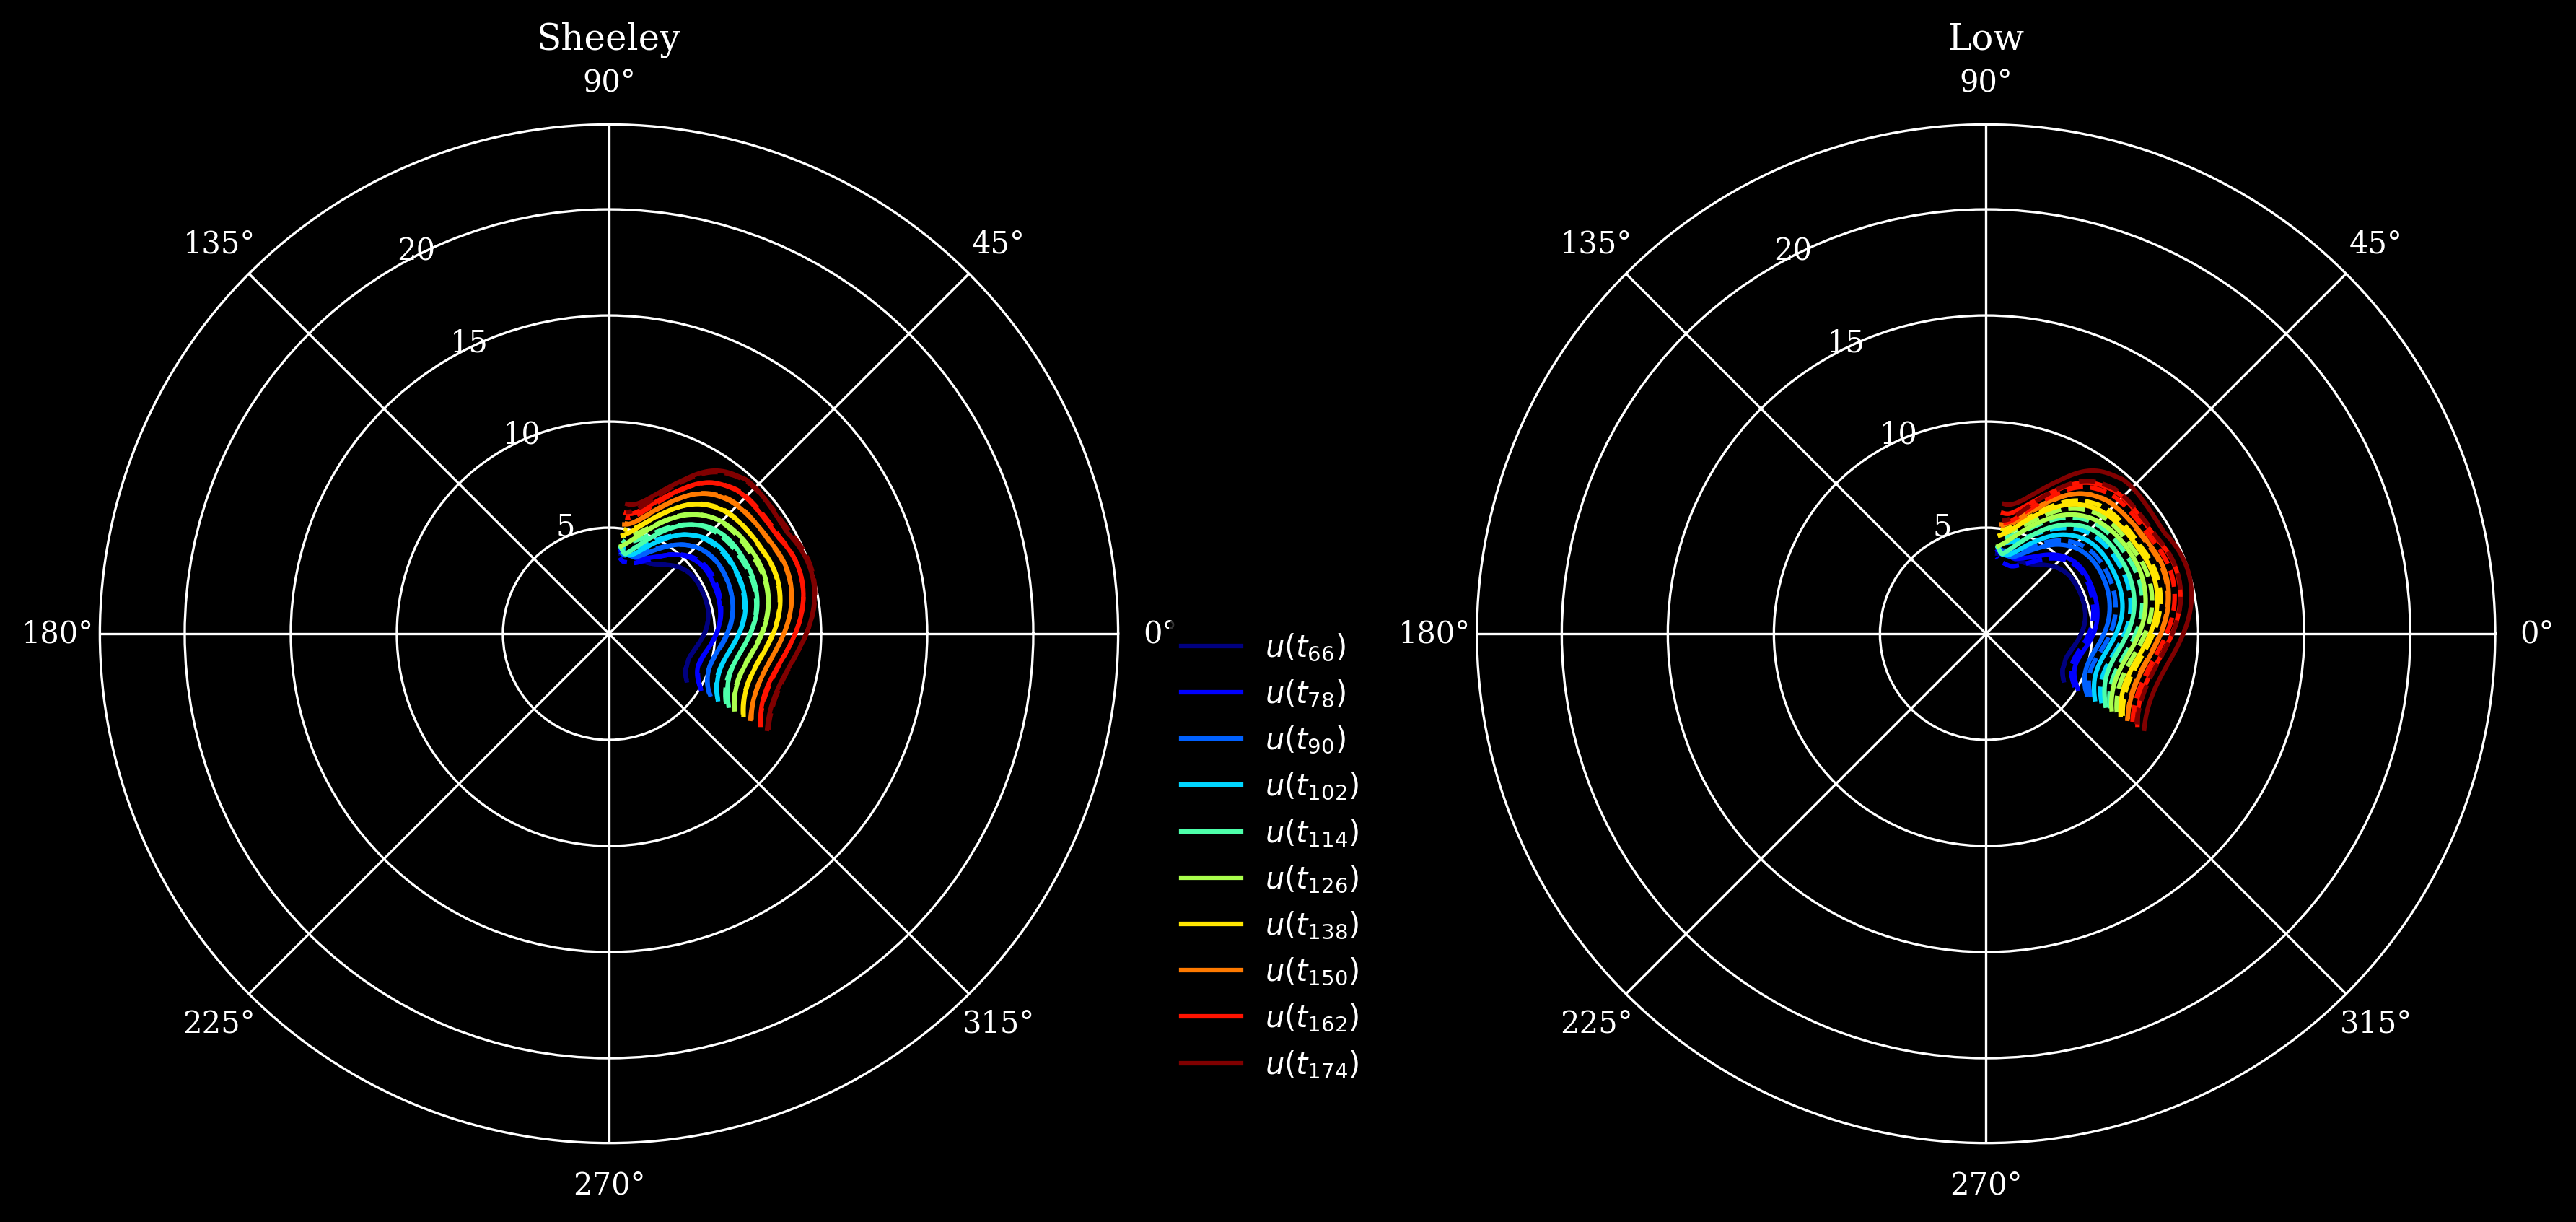

In [41]:
edut.plotTrainPredData2Models(r_vals_s1, r_pred_s1, r_pred_s1_low, ed_2161, sd_2161, simIdx=1)

Remove some sim IDs first, we won't fit models to these.

In [42]:
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142,193, 218, 253, 264, 273, 312, 313, 324])

In [43]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)
sd_modified

array([ 31,  32,  34,  35,  36,  37,  38,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  56,  57,  58,  59,
        60,  61,  62,  64,  65,  66,  67,  68,  69,  70,  71,  72,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 114, 115,
       118, 119, 120, 121, 122, 123, 124, 126, 127, 129, 130, 132, 133,
       134, 135, 136, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 166, 168, 169, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 183, 184, 185, 186, 188, 190, 191, 192, 194,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 23

In [44]:
train_model_pred_dir = "./train_2models_comparison"

In [46]:
# sheeley_params = np.zeros((160, 3, len(sd_modified)))
# low_params = np.zeros((160, 2, len(sd_modified)))

# for i in range(len(sd_modified)):
#     params_sheeley, r_pred_sheeley, r_vals_sheeley = fit_sheeley_exp(ed_2161, sd_modified, simIdx=i, lsq_loss="linear")
#     params_low, r_pred_low, r_vals_low = fit_low_ss(ed_2161, sd_modified, simIdx=i, lsq_loss="linear")
    
#     sheeley_params[:, :, i] = params_sheeley
#     low_params[:, :, i] = params_low
    
#     edut.plotTrainPredData2Models(r_vals_sheeley, r_pred_sheeley, r_pred_low, ed_2161, sd_modified, simIdx=i, 
#                                   savefig=True,
#                                   savedir=train_model_pred_dir
#                                  )

In [51]:
# np.save("./sheeley_params_selected_sims.npy", sheeley_params)

In [50]:
# np.save("./low_params_selected_sims.npy", low_params)

In [53]:
# np.save("./selected_simIDs_2161.npy", sd_modified)

In [54]:
# plot param values as a function of position angle

In [55]:
sp = np.load("./sheeley_params_selected_sims.npy")
lp = np.load("./low_params_selected_sims.npy")

In [56]:
sp_0 = sp[:, :, 0]
lp_0 = lp[:, :, 0]

In [60]:
param_labels=["k", "tau", "c1"]

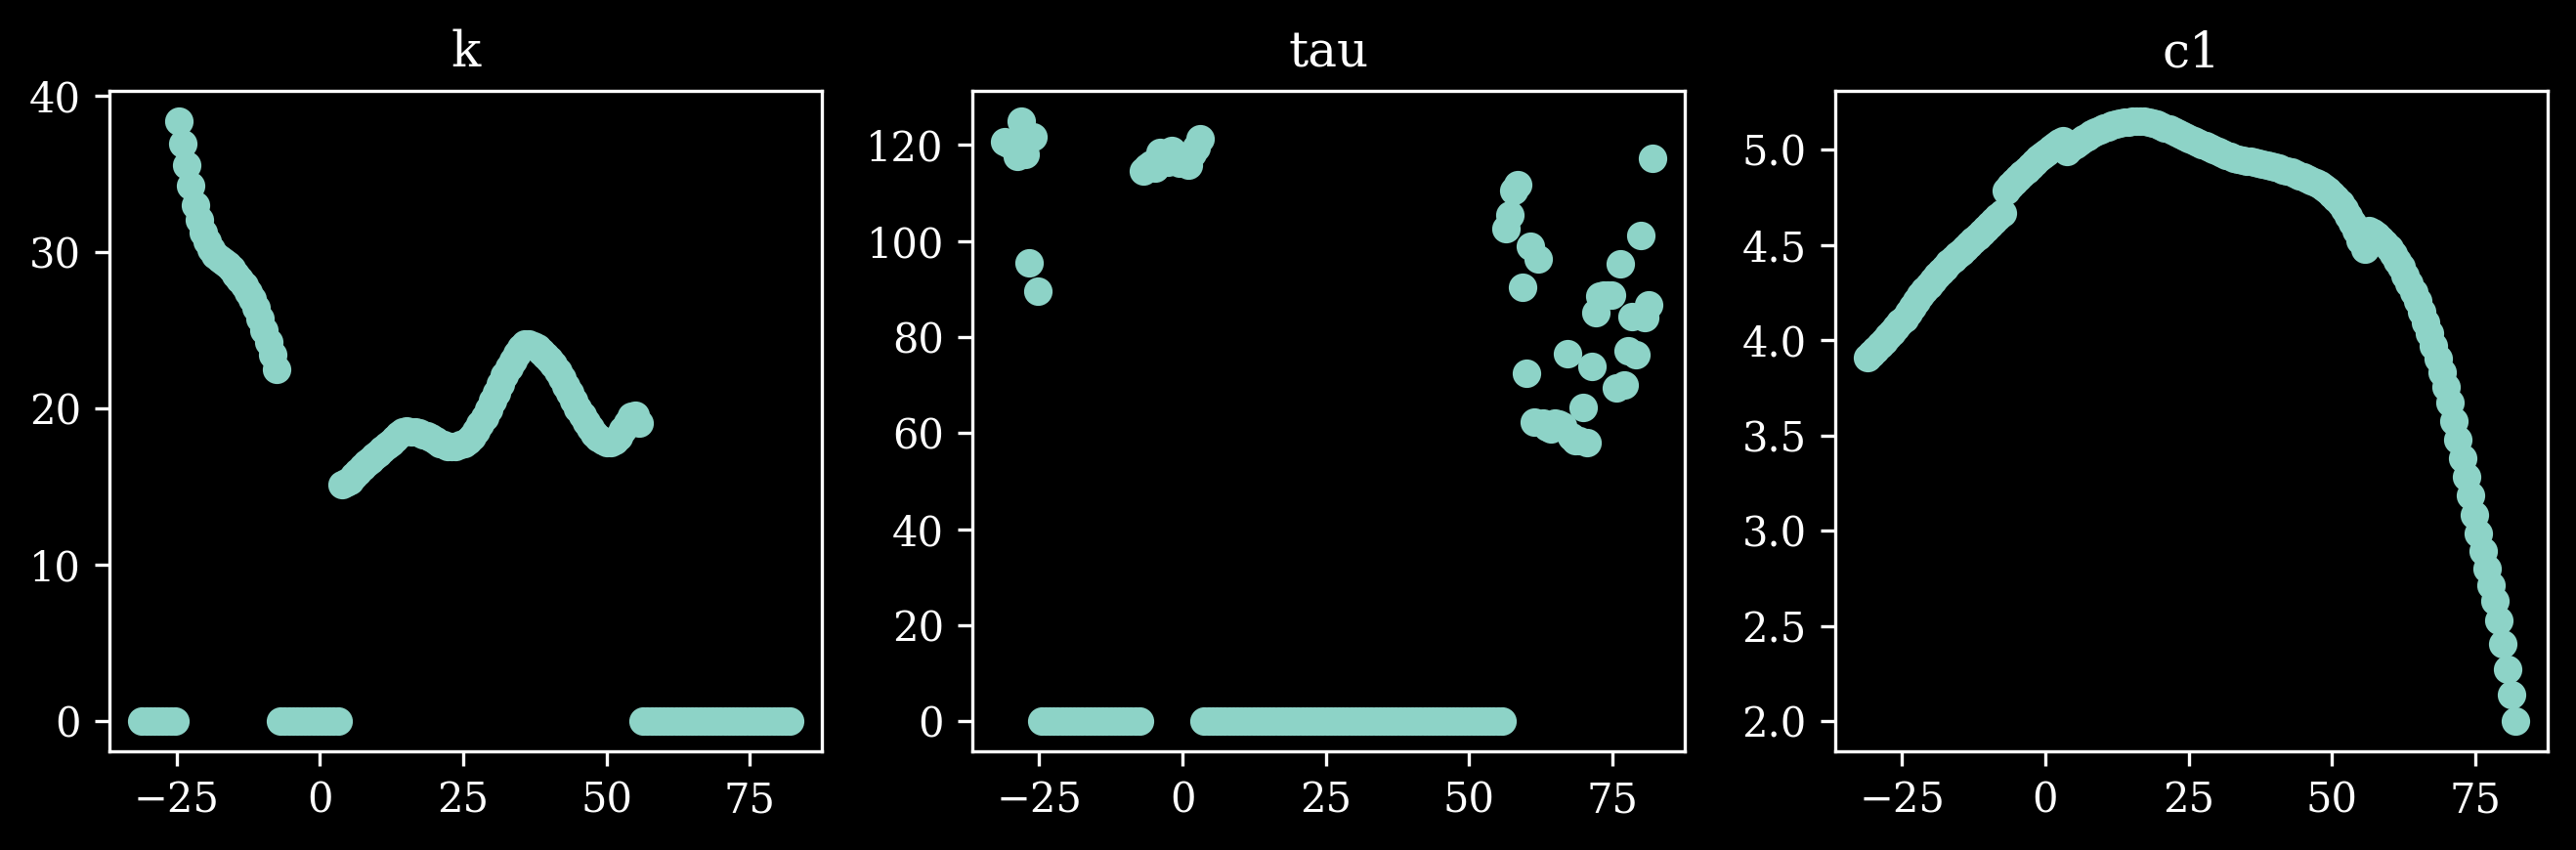

In [74]:
fig = plt.figure()
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    plt.scatter(np.linspace(-31, 82, 160), sp[:, :, 35][:, i])
    plt.title(param_labels[i])

1. change loss function to `soft l1` loss and check variation.

In [75]:
params_s0, r_pred_s0, r_vals_s0 = fit_sheeley_exp(ed_2161, sd_2161, simIdx=0, lsq_loss="soft_l1")
params_s0_low, r_pred_s0_low, r_vals_s0_low = fit_low_ss(ed_2161, sd_2161, simIdx=0, lsq_loss="soft_l1")

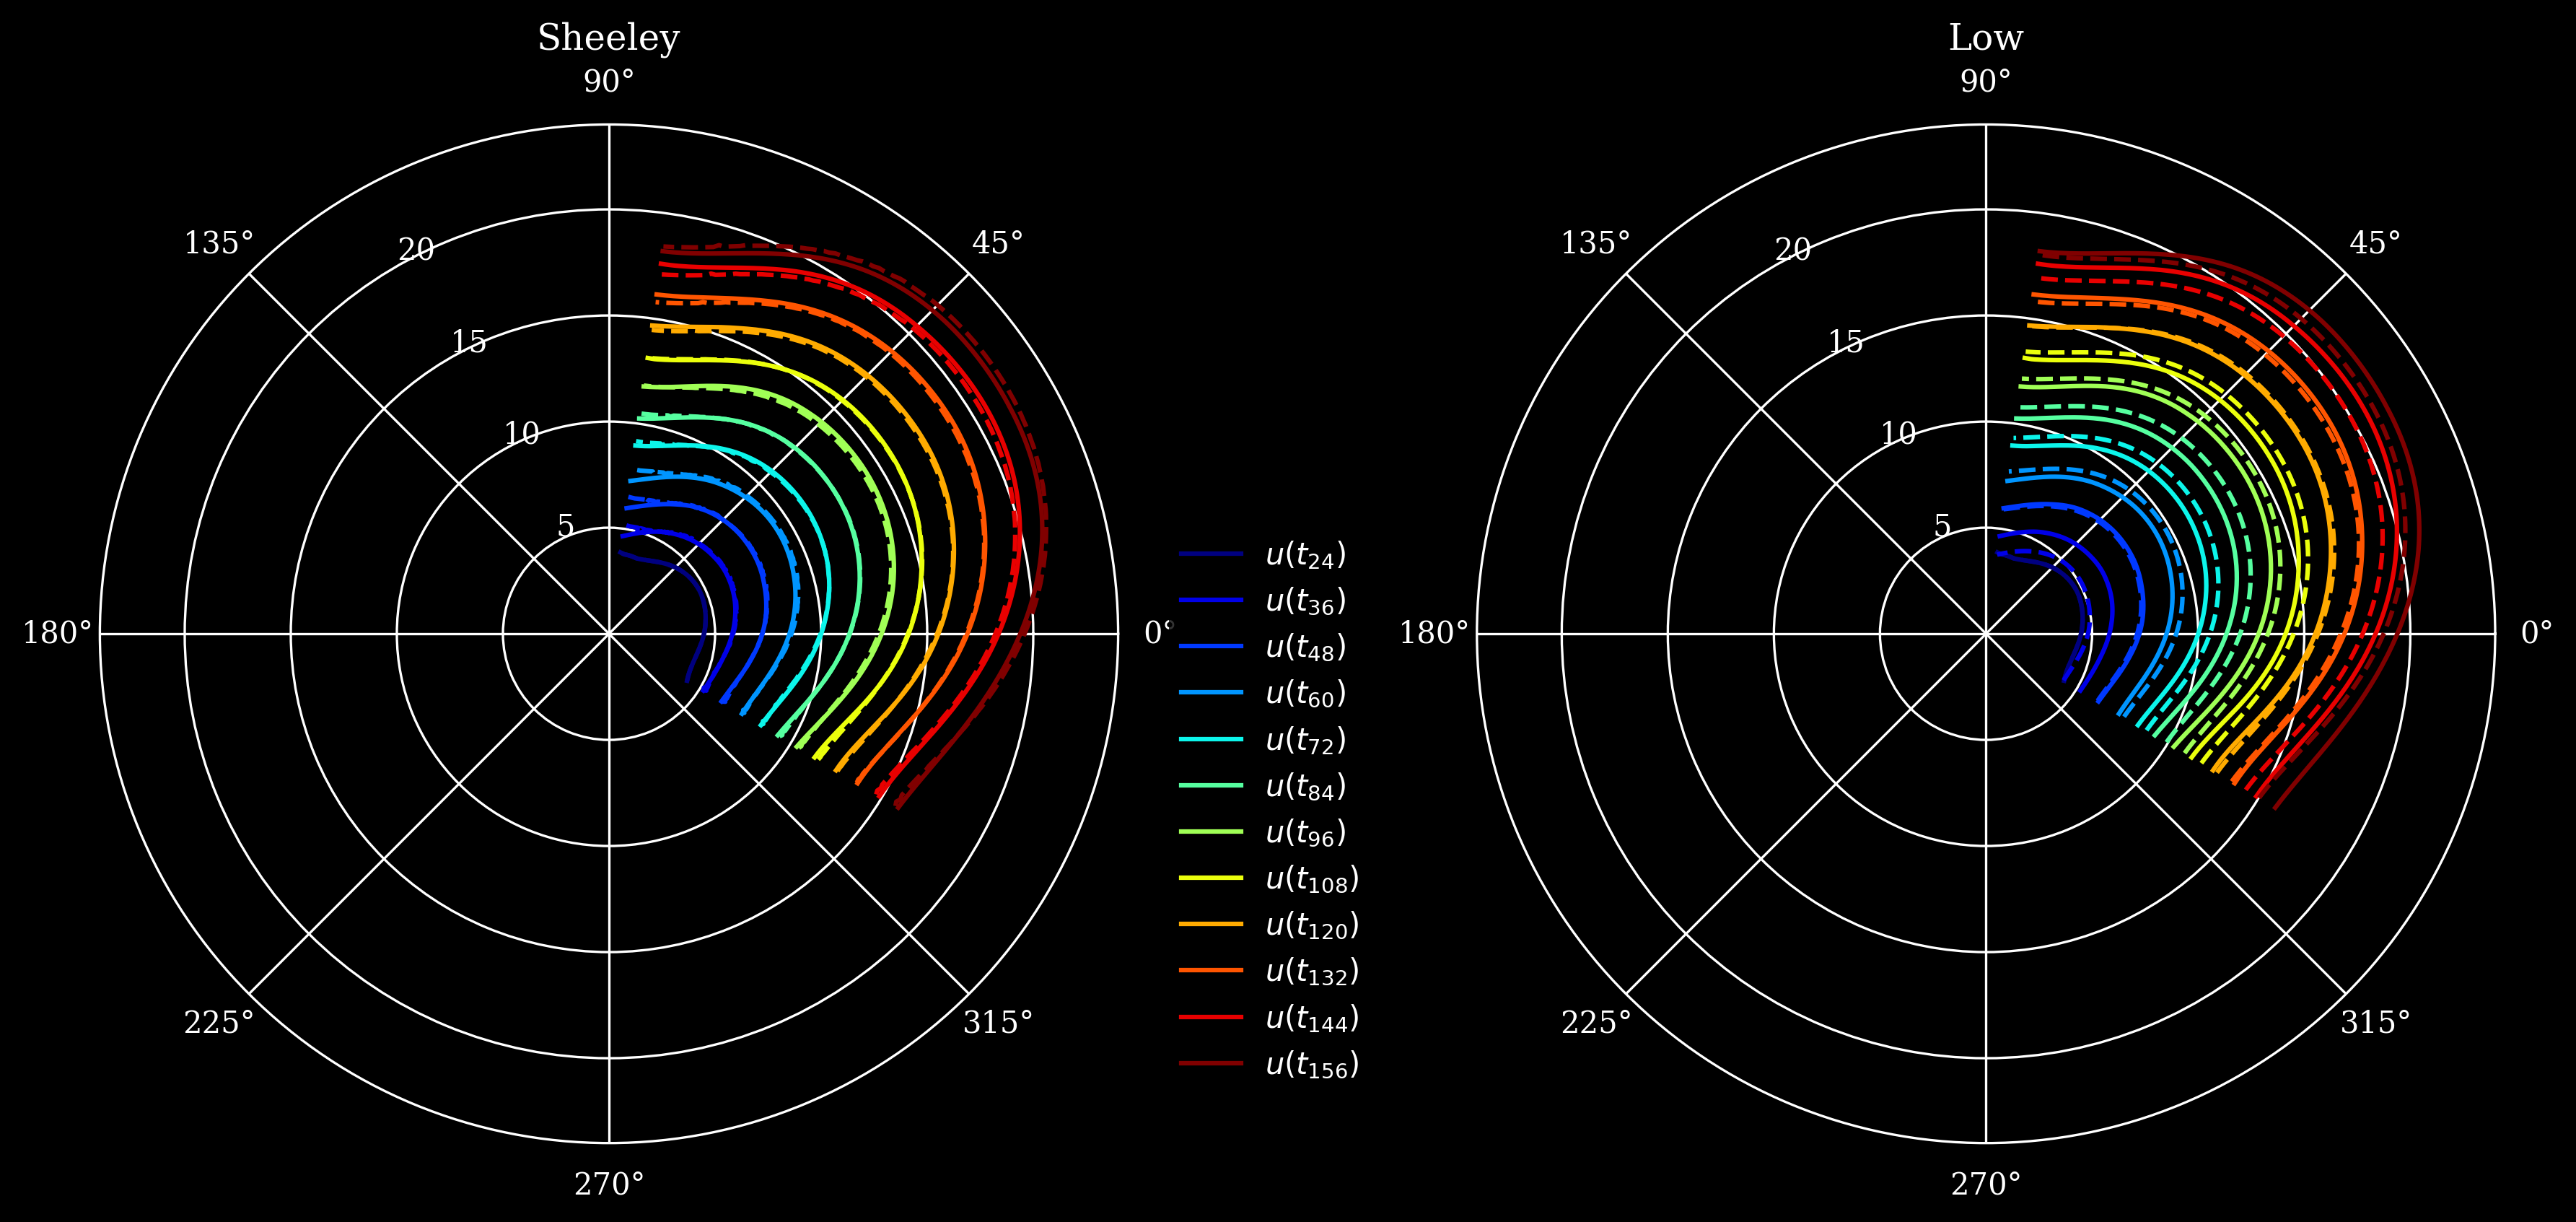

In [76]:
edut.plotTrainPredData2Models(r_vals_s0, r_pred_s0, r_pred_s0_low, ed_2161, sd_2161, simIdx=0)

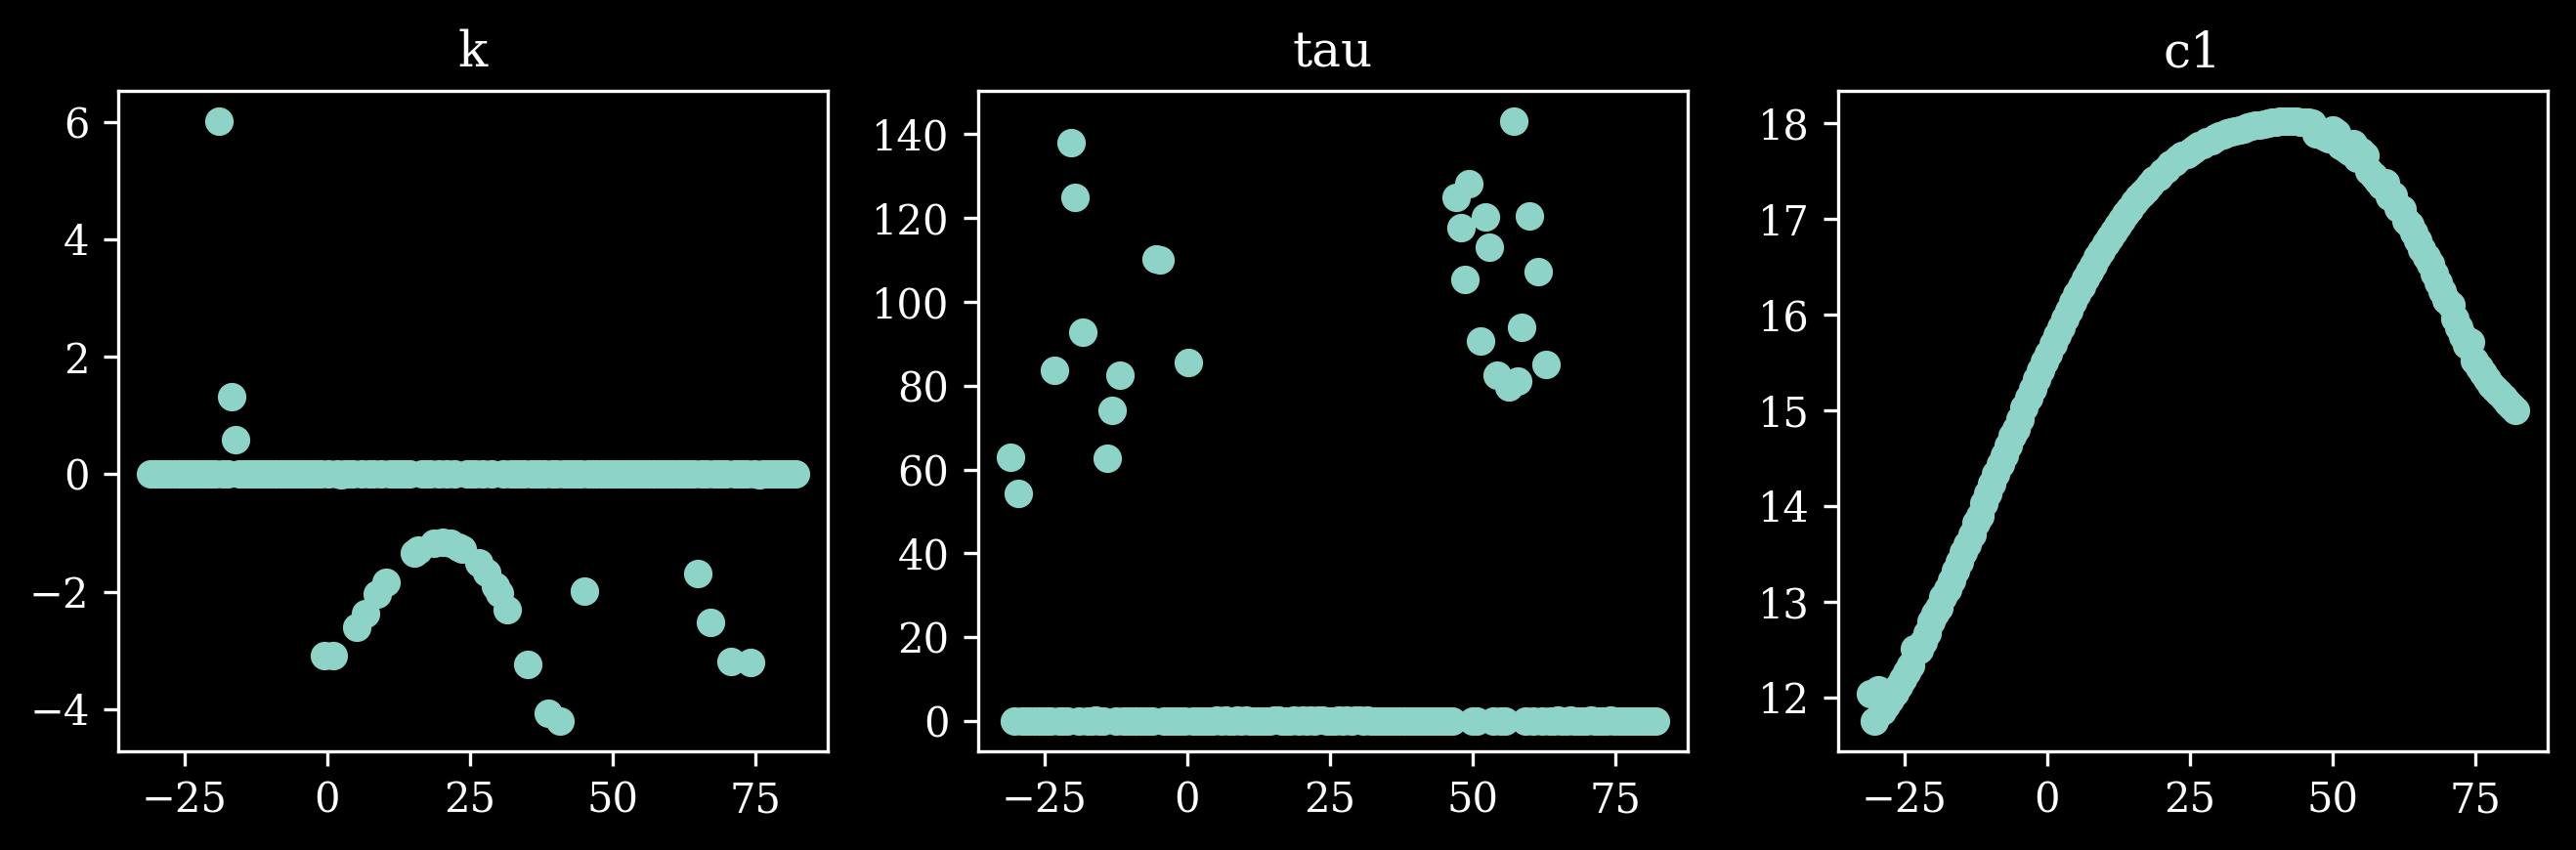

In [77]:
fig = plt.figure()
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    plt.scatter(np.linspace(-31, 82, 160), params_s0[:, i])
    plt.title(param_labels[i])

In [79]:
params_s0[:, 1]

array([6.29019552e+01, 4.03993273e-06, 5.43929112e+01, 4.03993676e-06,
       4.03993900e-06, 4.03994143e-06, 4.03994367e-06, 4.03994631e-06,
       4.03994893e-06, 4.03995160e-06, 4.03995448e-06, 8.35960224e+01,
       2.80459987e-04, 4.03996334e-06, 4.03996658e-06, 1.37900130e+02,
       1.24800423e+02, 5.35406353e-02, 9.28102735e+01, 1.27431125e-04,
       1.13526347e-01, 1.58746414e-01, 4.03999330e-06, 3.08001388e-03,
       6.26615511e+01, 7.41877596e+01, 4.04000765e-06, 8.25384196e+01,
       4.04001477e-06, 4.04001847e-06, 4.04002195e-06, 5.73867864e-02,
       4.04002919e-06, 4.04003281e-06, 4.04003643e-06, 4.04003999e-06,
       1.10230682e+02, 1.09920263e+02, 4.04005050e-06, 4.04005384e-06,
       4.04005726e-06, 4.04006061e-06, 4.04006395e-06, 1.28982660e-01,
       8.54851262e+01, 1.35258149e-01, 4.04007693e-06, 1.96923454e-03,
       4.04008308e-06, 2.25674706e-04, 4.04008907e-06, 1.55271795e-01,
       4.04009492e-06, 1.63815402e-01, 4.04010036e-06, 1.19425385e-04,
      

In [80]:
np.exp(-0.2/0.00005)

0.0

2. piecewise linear stuff

3. Neural ODEs (we don't need to reduce anything!)

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim

In [83]:
adjoint=True

In [84]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [85]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [168]:
tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx=1)

In [169]:
tMin

66.0

In [170]:
tMax

180

In [171]:
valid_times = np.arange(tMin, tMax + 2, step=2)
valid_times

array([ 66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180.])

In [172]:
tTrainEnd = tMin + np.floor((2/3)*(tMax - tMin))
tTrainEnd

142.0

In [173]:
trainEndIdx = np.argwhere(valid_times == tTrainEnd)[0][0]
trainEndIdx

38

In [174]:
tTrain = valid_times[:(trainEndIdx + 1)]

In [175]:
tTest = valid_times[(trainEndIdx + 1):]
tTest

array([144., 146., 148., 150., 152., 154., 156., 158., 160., 162., 164.,
       166., 168., 170., 172., 174., 176., 178., 180.])

In [176]:
tTrainScaled = (tTrain - tMin) / (tMax - tMin)
tTestScaled = (tTest - tMin) / (tMax - tMin)

In [177]:
tAllScaled = (valid_times - tMin) / (tMax - tMin)

In [178]:
nTrain = len(tTrain)
nTrain

39

In [180]:
y0_train_orig = r_vals_s1[0, :]
y0_train_torch = torch.from_numpy(np.float32(y0_train_orig))
y0_train_torch = y0_train_torch.reshape((1, len(y0_train_torch))).to(device)
y0_train_torch.shape

torch.Size([1, 160])

In [181]:
ytrain_orig = r_vals_s1[:(trainEndIdx + 1), :]
y_train_torch = torch.from_numpy(np.expand_dims(np.float32(ytrain_orig), axis=1)).to(device)

In [182]:
y_train_torch.shape

torch.Size([39, 1, 160])

In [183]:
y_train_torch.dtype

torch.float32

In [184]:
tTrain_torch = torch.tensor(np.float32(tTrainScaled)).to(device)
tTrain_torch.shape[0]

39

In [185]:
data_size = tTrain_torch.shape[0]
batch_time = 5
batch_size = 10

In [186]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64),
                                          batch_size, replace=False))
    batch_y0 = y_train_torch[s]
    batch_t = tTrain_torch[:batch_time]  # (T)
    batch_y = torch.stack([y_train_torch[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [187]:
by0, bt, by = get_batch()

In [188]:
by.shape

torch.Size([5, 10, 1, 160])

In [189]:
by0.shape

torch.Size([10, 1, 160])

In [190]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [191]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(160, 300),
            nn.Tanh(),
            nn.Linear(300, 160),
        )
        
        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
    def forward(self, t, y):
        return self.net1(y)

In [192]:
import time

In [193]:
ii = 0
func = ODEFunc().to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

In [194]:
niters=1000
test_freq=5

In [195]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

step_loss = []
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    step_loss.append(loss.item())
    
    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, y0_train_torch, tTrain_torch)
            loss = torch.mean(torch.abs(pred_y - y_train_torch))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            ii += 1

    end = time.time()

Iter 0005 | Total Loss 1.101601
Iter 0010 | Total Loss 0.697774
Iter 0015 | Total Loss 0.401126
Iter 0020 | Total Loss 0.248762
Iter 0025 | Total Loss 0.203162
Iter 0030 | Total Loss 0.187248
Iter 0035 | Total Loss 0.167527
Iter 0040 | Total Loss 0.149697
Iter 0045 | Total Loss 0.146072
Iter 0050 | Total Loss 0.153979
Iter 0055 | Total Loss 0.155275
Iter 0060 | Total Loss 0.130321
Iter 0065 | Total Loss 0.100470
Iter 0070 | Total Loss 0.100895
Iter 0075 | Total Loss 0.109427
Iter 0080 | Total Loss 0.116354
Iter 0085 | Total Loss 0.114453
Iter 0090 | Total Loss 0.135613
Iter 0095 | Total Loss 0.113416
Iter 0100 | Total Loss 0.106918
Iter 0105 | Total Loss 0.105609
Iter 0110 | Total Loss 0.129607
Iter 0115 | Total Loss 0.135123
Iter 0120 | Total Loss 0.128284
Iter 0125 | Total Loss 0.096889
Iter 0130 | Total Loss 0.119391
Iter 0135 | Total Loss 0.124923
Iter 0140 | Total Loss 0.128756
Iter 0145 | Total Loss 0.111833
Iter 0150 | Total Loss 0.117233
Iter 0155 | Total Loss 0.107751
Iter 016

In [151]:
# torch.save(func.state_dict(), "dydt_Ay_Sim031_2161_1000_steps.pt")

In [196]:
tAllScaled_torch = torch.tensor(np.float32(tAllScaled)).to(device)

with torch.no_grad():
    yTrajPred_full_torch = odeint(func, y0_train_torch, tAllScaled_torch)

In [197]:
yTrajPred = yTrajPred_full_torch.cpu().numpy()[:, 0, :]

In [198]:
yTrajPred.shape

(58, 160)

In [199]:
yTrajPred

array([[4.2653174, 4.2173023, 4.1733055, ..., 3.820806 , 3.8192945,
        3.816997 ],
       [4.3501673, 4.3057885, 4.2595334, ..., 3.84217  , 3.8466718,
        3.8494287],
       [4.4349494, 4.394173 , 4.3457165, ..., 3.8631768, 3.8735359,
        3.8812997],
       ...,
       [8.398386 , 8.467874 , 8.406788 , ..., 5.1909266, 4.5977325,
        4.5389256],
       [8.467132 , 8.53845  , 8.477339 , ..., 5.2304053, 4.614156 ,
        4.5511603],
       [8.53587  , 8.609021 , 8.547878 , ..., 5.270139 , 4.63076  ,
        4.563593 ]], dtype=float32)

The figure below shows all trajectories from a given sim on the left, and predictions made for the full time series starting from the given IC using NODE on the right!

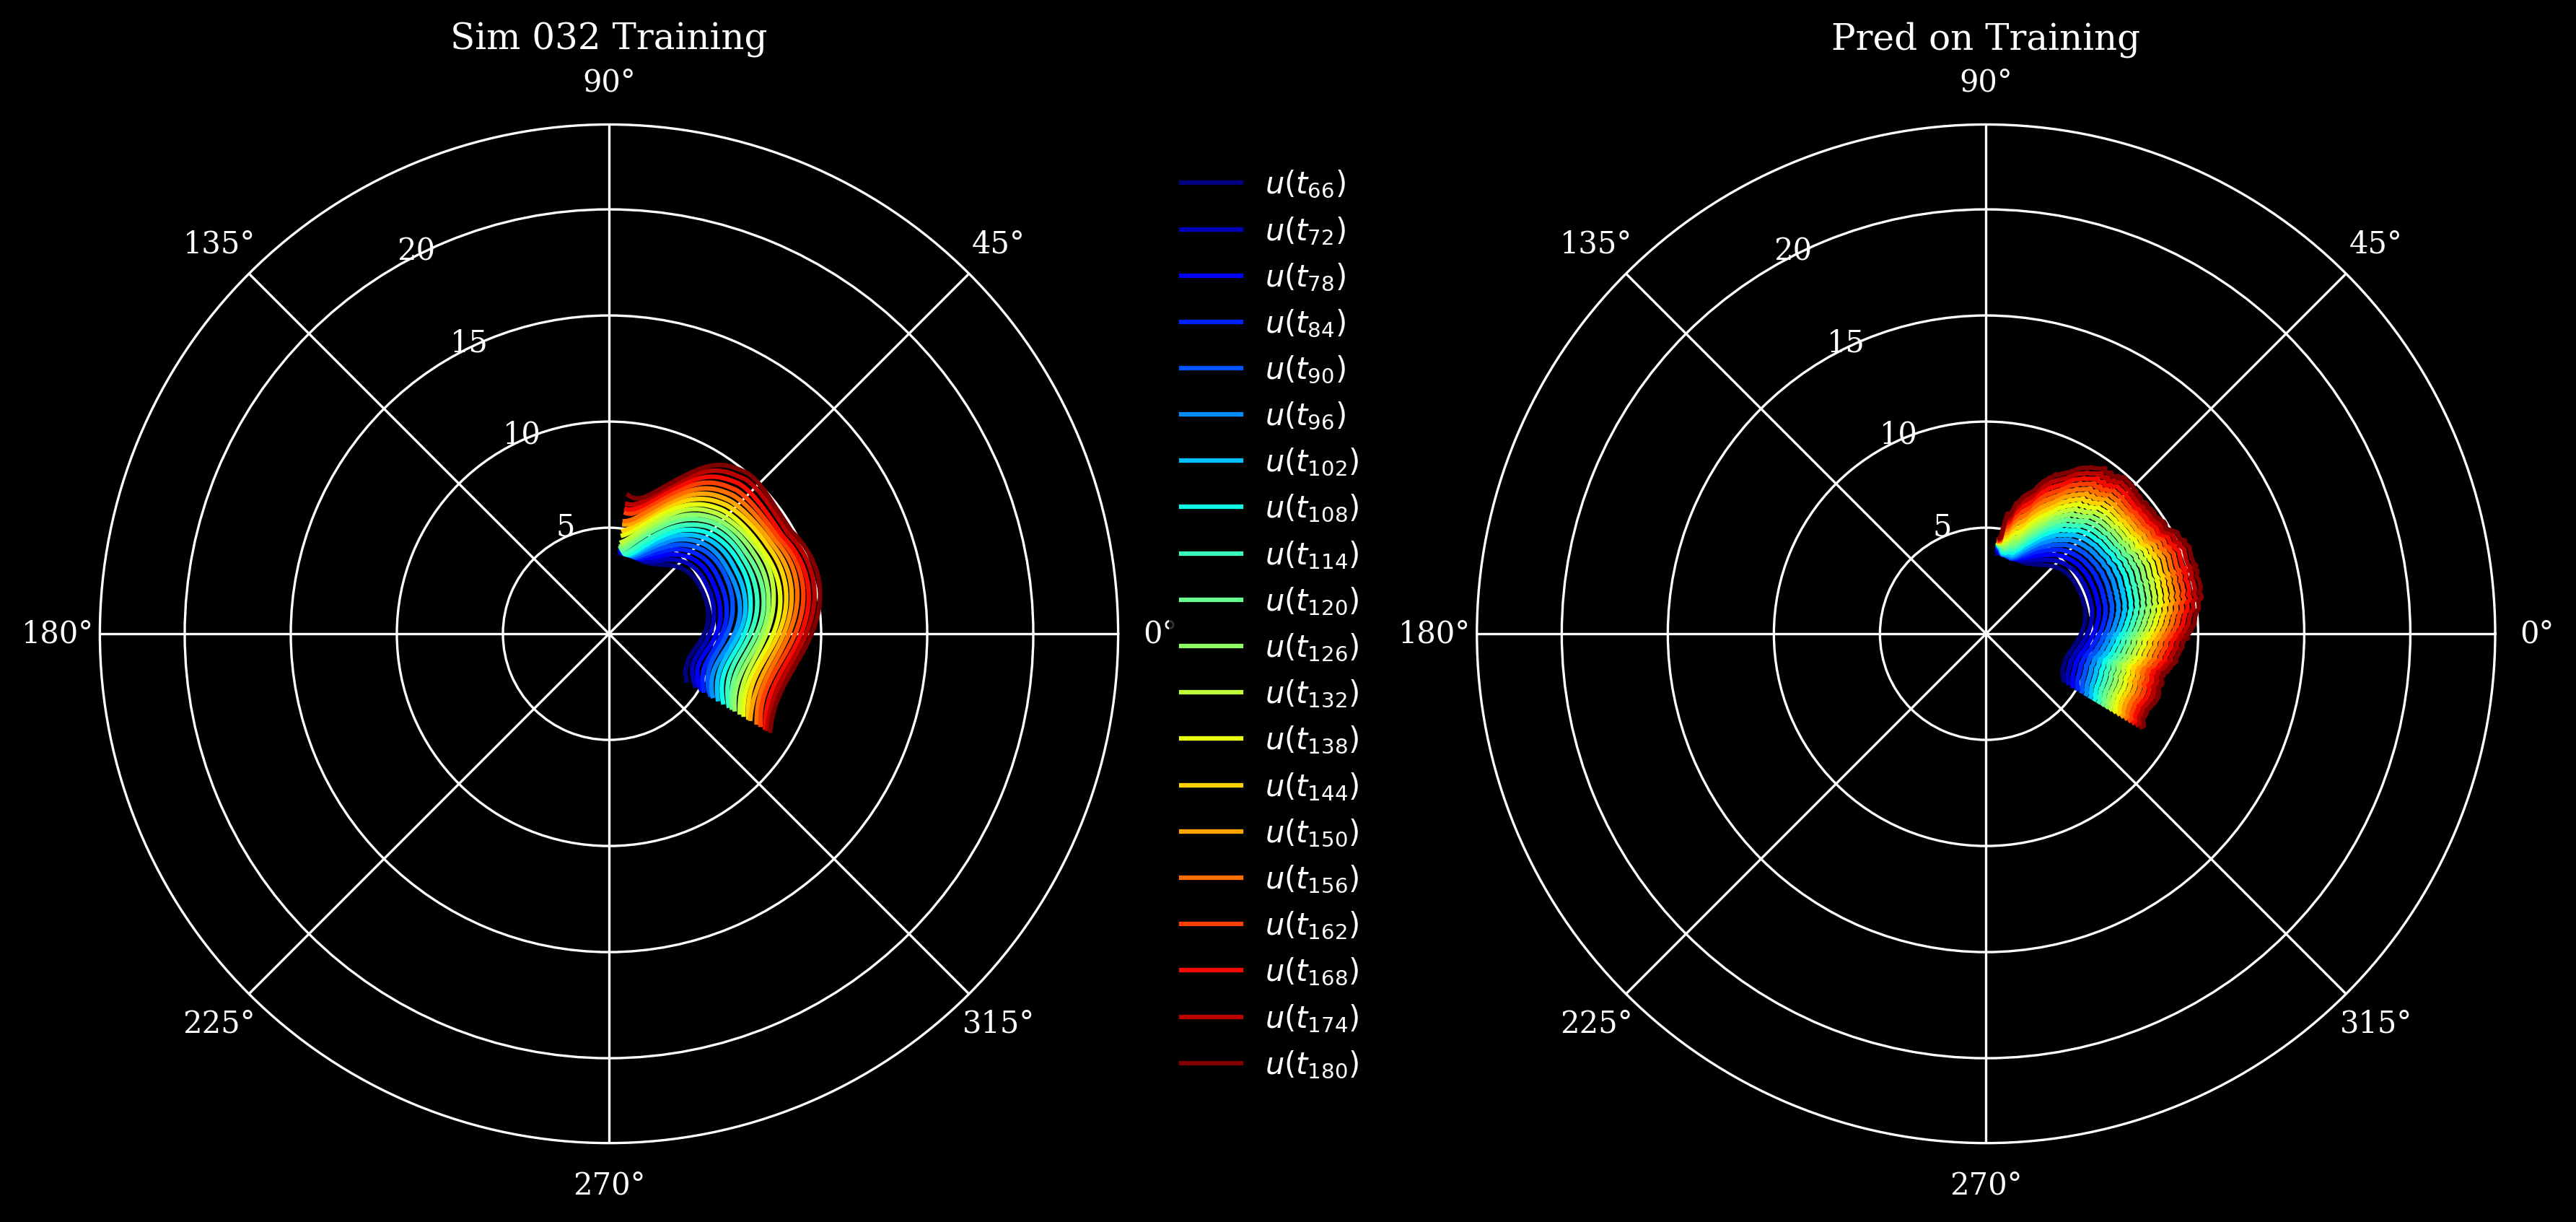

In [200]:
edut.plotTrainPredData(r_vals_s1, yTrajPred, ed_2161, sd_modified, theta=np.linspace(-31, 82, 160), simIdx=1, savefig=False)

In [201]:
def plotTrainPredData1Model(r_train, r_pred1, edge_data_matrix, sim_data, theta=np.linspace(-31, 82, 160), simIdx=0,
                            savefig=False,
                            savedir="./train_1model_comparison"):
    
    # get Sim ID
    simID = sim_data[simIdx]
    
    # get minimum and max bounds (i.e. where edge appears and where edge is very close to boundary)
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)

    all_times = np.linspace(2, 180, 90)

    #     # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]

    valid_times_to_plot = np.arange(tMin, tMax + 2, step=12)

    valid_time_idx = np.array([np.where(valid_times == i)[0][0] for i in valid_times_to_plot])
    
    #     return valid_time_idx
    fig = plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(121, projection='polar')

    color = iter(plt.cm.jet(np.linspace(0, 1, len(valid_times_to_plot))))

    
    for i, j in enumerate(valid_time_idx):
        cc = next(color)
        ax1.plot(theta * np.pi/180, r_train[j, :], color=cc, label=fr"$u(t_{{{int(valid_times_to_plot[i])}}})$")
        ax1.plot(theta * np.pi/180, r_pred1[j, :], color=cc, linestyle='dashed', label="")


    
    ax1.set_rlabel_position(120)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.set_rmax(24)
    ax1.grid(True)

    ax1.legend(loc=(1.05, 0.05))
    
    ax1.set_title("Training and Predictions Sim {}".format(simID))
        
    fig.tight_layout()
   
    if savefig:
        plt.savefig(os.path.join(savedir, "run_{:03d}.png".format(simID)),
                   bbox_inches="tight", pad_inches=0)
        print("Saved image for Sim {:03d}".format(simID))
        plt.close()

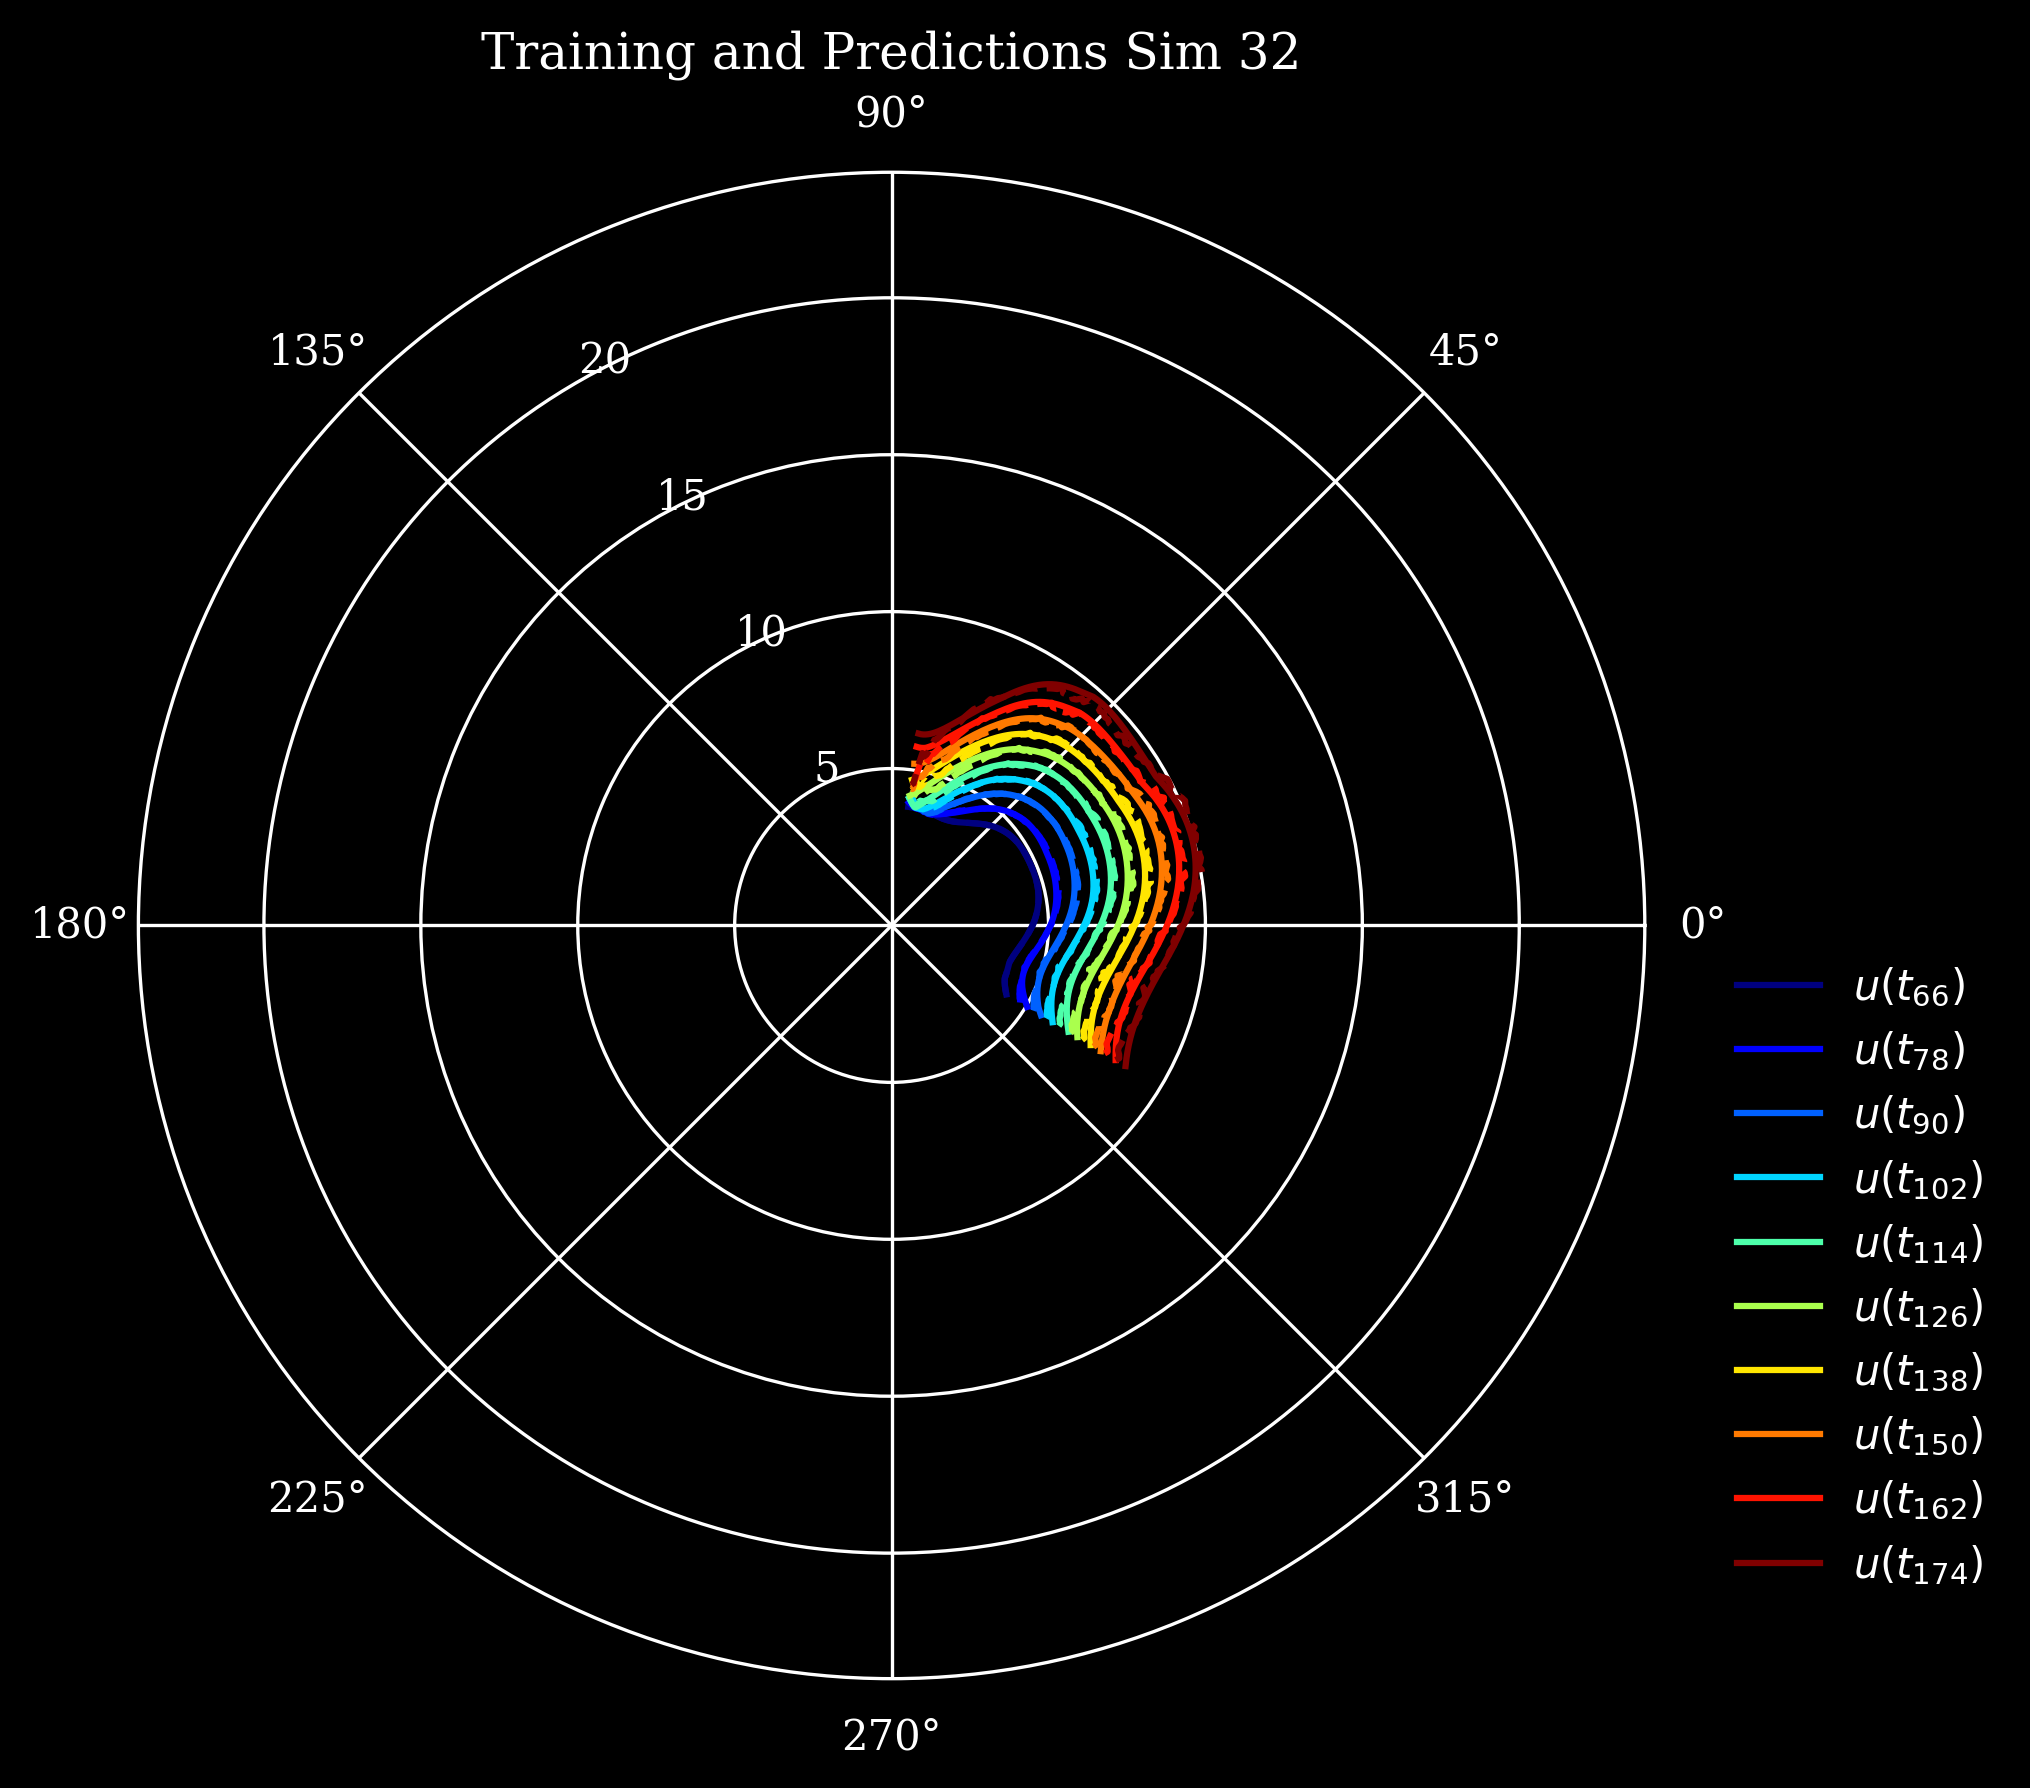

In [203]:
plotTrainPredData1Model(r_vals_s1, yTrajPred, ed_2161, sd_modified, theta=np.linspace(-31, 82, 160), 
                        simIdx=1,
                        savefig=False)

Operator Interpolation?

The next notebook (notebook 04) `04_mixture_density_networks_for_mapping_RVs` will explore the harder problem of mapping between the fit parameters and flux rope parameters. The caveat is that we want to use the true values of the parameters directly this time as opposed to the independent perturbations and do inference on these true values directly, so learning something simple like the Polynomial Chaos mapping _may_ not be the best idea (dependency structure, high-dim space if we also include the "latent background params"! so on and so forth).

Instead we will see if we can parametrize an MDN (mixture density network) and see how we do with that!